In [3]:
import duckdb
import pandas as pd
from statsbombpy import sb

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gravis as gv
import networkx as nx

import scipy.stats as stats
import matplotlib.colors as mcolors
import matplotlib.cm as cm

from scipy.optimize import curve_fit


# db yi güncelle sonra asist sayısını getir

In [4]:
con = duckdb.connect("laliga.db")


In [5]:
passes = con.execute("SELECT * FROM events WHERE type = 'Pass'").df()


In [6]:

columnsp = [
    "match_id",
    "competition",
    "home_team",
    "home_score",
    "away_team",
    "away_score",
    "referee",
    "team",
    "possession",
    "possession_time",
    "minute",
    "timestamp",
    "player",
    "position",
    "position_most_played",
    "x",
    "y",
    "pass_end_x",
    "pass_end_y",
    "pass_length",
    "pass_recipient",
    "pass_recipient_id",
    "position_re_most_played",
    "pass_recipient_position",
    "player_shotFromPass",
    "shot_type_shotFromPass",
    "shot_outcome_shotFromPass",
    "shot_statsbomb_xg_shotFromPass",
    'SequenceXG',
    "SequenceType",
    "SequenceBuildUpXG",
    "pass_succes",
    "pass_outcome",
]

pdf=passes[columnsp]



In [7]:
pdf.head(5)

match_id      competition   home_team  home_score away_team  away_score  \
0   3825848  Spain - La Liga  Levante UD           2     Eibar           2   
1   3825848  Spain - La Liga  Levante UD           2     Eibar           2   
2   3825848  Spain - La Liga  Levante UD           2     Eibar           2   
3   3825848  Spain - La Liga  Levante UD           2     Eibar           2   
4   3825848  Spain - La Liga  Levante UD           2     Eibar           2   

  referee   team  possession  possession_time  ...  pass_recipient_position  \
0    None  Eibar           2           19.824  ...                     None   
1    None  Eibar           2           19.824  ...                     None   
2    None  Eibar           2           19.824  ...                     None   
3    None  Eibar           2           19.824  ...                     None   
4    None  Eibar           2           19.824  ...         Left Center Back   

  player_shotFromPass shot_type_shotFromPass shot_outcome_shotFromPass  \
0                None                   None                      None   
1                None                   None                      None   
2                None                   None                      None   
3                None                   None                      None   
4                None                   None                      None   

  shot_statsbomb_xg_shotFromPass  SequenceXG  SequenceType  SequenceBuildUpXG  \
0                            NaN         0.0        NoShot                0.0   
1                            NaN         0.0        NoShot                0.0   
2                            NaN         0.0        NoShot                0.0   
3                            NaN         0.0        NoShot                0.0   
4                            NaN         0.0        NoShot                0.0   

   pass_succes  pass_outcome  
0         True          None  
1         True          None  
2         True          None  
3         True          None  
4         True          None  

[5 rows x 33 columns]

In [8]:
pdf["SequenceXG"] = pd.to_numeric(pdf["SequenceXG"], errors="coerce")
pdf["SequenceBuildUpXG"] = pd.to_numeric(pdf["SequenceBuildUpXG"], errors="coerce")


/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_27390/2228938483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["SequenceXG"] = pd.to_numeric(pdf["SequenceXG"], errors="coerce")
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_27390/2228938483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["SequenceBuildUpXG"] = pd.to_numeric(pdf["SequenceBuildUpXG"], errors="coerce")


In [9]:
def network_creation(match_pass_data):
    # Create a copy of the match_pass_data to avoid modifying the original DataFrame
    df = match_pass_data.copy()

    # Only keep successful passes with valid recipients
    df = df[(df['pass_succes']) & (df['pass_recipient'].notna())]

    # Initialize a directed graph
    G = nx.DiGraph()

    # Add edges with weights to the graph
    for _, row in df.iterrows():
        if G.has_edge(row['player'], row['pass_recipient']):
            # Increment weight if the edge already exists
            G[row['player']][row['pass_recipient']]['weight'] += 1
        else:
            # Add edge with an initial weight of 1
            G.add_edge(row['player'], row['pass_recipient'], weight=1)

    # Calculate centrality measures
    try:
        degree_centrality = nx.degree_centrality(G)
        eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
        closeness_centrality = nx.closeness_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)
    except nx.PowerIterationFailedConvergence:
        print("Error: Eigenvector centrality did not converge. Check the graph structure.")

    # Convert centrality measures to DataFrames
    degree_c = pd.DataFrame(list(degree_centrality.items()), columns=['player', 'degree_c'])
    eigen_c = pd.DataFrame(list(eigenvector_centrality.items()), columns=['player', 'eigen_c'])
    closeness_c = pd.DataFrame(list(closeness_centrality.items()), columns=['player', 'closeness_c'])
    betweenness_c = pd.DataFrame(list(betweenness_centrality.items()), columns=['player', 'betweenness_c'])
    
    #print(df["pass_succes"].unique())    # Perform left joins with the main DataFrame to add centrality measures
    
    result_df = df.merge(degree_c, on='player', how='left')
    result_df = result_df.merge(eigen_c, on='player', how='left')
    result_df = result_df.merge(closeness_c, on='player', how='left')
    result_df = result_df.merge(betweenness_c, on='player', how='left')
    #print(result_df["pass_succes"].unique())    # Perform left joins with the main DataFrame to add centrality measures


    # Return the graph and the updated DataFrame
    return G, result_df




def network_viz(df, G):
    # Compute player positions
    pass_positions = df[['player', 'x', 'y']].rename(columns={'x': 'pos_x', 'y': 'pos_y'})
    receive_positions = df[['pass_recipient', 'pass_end_x', 'pass_end_y']].rename(
        columns={'pass_recipient': 'player', 'pass_end_x': 'pos_x', 'pass_end_y': 'pos_y'}
    )

    # Combine pass and receive positions
    all_positions = pd.concat([pass_positions, receive_positions], ignore_index=True)

    # Calculate average positions
    average_positions_df = all_positions.groupby('player')[['pos_x', 'pos_y']].mean()

    # Convert to dictionary for NetworkX
    average_positions = average_positions_df.apply(lambda row: (row['pos_x'], row['pos_y']), axis=1).to_dict()

    # Node size calculation (based on degree centrality)
    centrality = nx.degree_centrality(G)  # Calculate centrality
    min_size, max_size = 10, 100  # Desired size range
    min_centrality = min(centrality.values(), default=0)
    max_centrality = max(centrality.values(), default=1)

    node_sizes = [
        min_size + ((centrality[node] - min_centrality) / (max_centrality - min_centrality)) * (max_size - min_size)
        for node in G.nodes
    ]

    # Node color calculation (based on SequenceXG)
    grouped = df.groupby('player')['SequenceXG'].sum().reset_index()
    grouped.set_index('player', inplace=True)
    norm = mcolors.Normalize(vmin=grouped['SequenceXG'].min(), vmax=grouped['SequenceXG'].max())
    colormap = cm.viridis
    node_colors = [
        mcolors.to_hex(colormap(norm(grouped.loc[node]['SequenceXG']))) if node in grouped.index else '#808080'
        for node in G.nodes
    ]

    # Get edge weights for visualization (scaled for thickness)
    weights = [data.get('weight', 1) * 0.01 for _, _, data in G.edges(data=True)]

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 8))

    # Add background field image
    try:
        field_image = plt.imread("pitch.png")  # Path to the football field image
        ax.imshow(field_image, extent=[0, 120, 80, 0], zorder=0)  # Adjust to field dimensions
    except FileNotFoundError:
        print("Field image not found. Please ensure 'pitch.png' is in the correct path.")

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, average_positions, node_size=node_sizes, node_color=node_colors, ax=ax, alpha=0.9)
    nx.draw_networkx_labels(G, average_positions, font_size=8, font_color="black", ax=ax)
    nx.draw_networkx_edges(
        G,
        average_positions,
        edge_color="gray",
        width=weights,
        arrowstyle='->',
        arrowsize=10,
        ax=ax
    )

    # Add colorbar for node colors
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('SequenceXG', rotation=90, labelpad=10)

    # Axis settings
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 80)
    ax.set_axis_off()  # Hide axes
    ax.invert_yaxis()  # Invert y-axis to match football field orientation

    plt.title("Passing Network")
    plt.show()




def agg_players(data,flag=0):
    # flag 0: takım
    # flag 1: oyuncu takım
    # flag 2: mevki takım  
    arr=[]
    if flag==0:
        arr.append("team")
    elif flag==1:
        arr.append("player")
        arr.append("team")
    elif flag==2:
        arr.append("position_most_played")
        arr.append("team")

    # Aggregation dictionary
    agg_dict = {
        'position': lambda x: x.mode()[0] if not x.mode().empty else None,
        'pass_length': 'mean',
        'pass_progression': 'mean',
        "possession_time":['sum',"mean"],
        'InSequenceID': 'mean',
        'time_past': 'mean',
        'degree_c': 'mean',
        'eigen_c': 'mean',
        'closeness_c': 'mean',
        'betweenness_c': 'mean',
        'pass_recipient': lambda x: x.mode()[0] if not x.mode().empty else None,
        'pass_recipient_position': lambda x: x.mode()[0] if not x.mode().empty else None,
        'shot_statsbomb_xg_shotFromPass': 'sum',
        'SequenceXG': 'sum',
        'SequenceBuildUpXG': 'sum',
        'pass_succes': "count",
        'f3rd_pass': 'sum',
        'shot_assisted_pass': 'sum',
        'goal_assisted_pass': 'sum',
        'cross': 'sum',
        'box_pass': 'sum',
        'match_id': 'mean'  # Unique count of match IDs

    }

    by_player = data.groupby(arr).agg(agg_dict)

    by_player.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in by_player.columns]

    # Reset the index for better readability
    by_player = by_player.reset_index()

    # Calculate pass success per total possession time
    #by_player['pass_rate'] = by_player['pass_succes_sum'] / by_player['possession_time_sum']

    return by_player





### Network oluşturma

In [10]:
# Dictionaries to store data
team_graphs = {}      # To store NetworkX graphs
team_dataframes = {}  # To store DataFrames
all_teams_dataframe = pd.DataFrame()

# Iterate over unique teams and populate the dictionaries
for team in pdf.team.unique():
    season_network, season_network_DF = network_creation(pdf[pdf["team"] == team])
    team_graphs[team] = season_network
    team_dataframes[team] = season_network_DF
    all_teams_dataframe = pd.concat([all_teams_dataframe, season_network_DF], ignore_index=True)

# Access data by team name
team_name = "Barcelona"  # Replace with the desired team name



In [11]:
df = team_dataframes[team_name][['player','player_shotFromPass',
       'shot_type_shotFromPass', 'shot_outcome_shotFromPass',
       'shot_statsbomb_xg_shotFromPass', 'SequenceXG', 'SequenceBuildUpXG',
       'pass_succes', 'pass_outcome']]
df['pass_outcome'].unique()

array([None], dtype=object)

In [12]:
df = all_teams_dataframe[["player",'team',"match_id","degree_c", "eigen_c", "closeness_c", "betweenness_c",'shot_outcome_shotFromPass',"shot_statsbomb_xg_shotFromPass","SequenceBuildUpXG", 'SequenceXG' ]]
df

player       team  match_id  degree_c   eigen_c  \
0        Adrián González Morales      Eibar   3825848  1.846154  0.229477   
1           Borja González Tomás      Eibar   3825848  1.730769  0.235909   
2         Daniel García Carrillo      Eibar   3825848  1.884615  0.234545   
3              Aleksandar Pantić      Eibar   3825848  1.615385  0.199169   
4        Mauro Javier Dos Santos      Eibar   3825848  1.846154  0.227825   
...                          ...        ...       ...       ...       ...   
276758              Ivan Rakitić  Barcelona    266557  1.875000  0.226338   
276759  Sergio Busquets i Burgos  Barcelona    266557  1.750000  0.221558   
276760          Jordi Alba Ramos  Barcelona    266557  1.833333  0.214830   
276761  Luis Alberto Suárez Díaz  Barcelona    266557  1.708333  0.226338   
276762  Sergio Busquets i Burgos  Barcelona    266557  1.750000  0.221558   

        closeness_c  betweenness_c shot_outcome_shotFromPass  \
0          0.928571       0.037141                      None   
1          0.962963       0.018717                      None   
2          0.928571       0.029844                      None   
3          0.787879       0.005694                      None   
4          0.896552       0.024964                      None   
...             ...            ...                       ...   
276758     0.923077       0.042719                      None   
276759     0.888889       0.004933                      None   
276760     0.888889       0.016070                      None   
276761     0.923077       0.007705                      None   
276762     0.888889       0.004933                      None   

        shot_statsbomb_xg_shotFromPass  SequenceBuildUpXG  SequenceXG  
0                                  NaN                0.0         0.0  
1                                  NaN                0.0         0.0  
2                                  NaN                0.0         0.0  
3                                  NaN                0.0         0.0  
4                                  NaN                0.0         0.0  
...                                ...                ...         ...  
276758                             NaN                0.0         0.0  
276759                             NaN                0.0         0.0  
276760                             NaN                0.0         0.0  
276761                             NaN                0.0         0.0  
276762                             NaN                0.0         0.0  

[276763 rows x 11 columns]

In [13]:
# Assign 1 if the value is 'Goal', otherwise 0
df['shot_outcome_shotFromPass_binary'] = df['shot_outcome_shotFromPass'].apply(lambda x: 1 if x == 'Goal' else 0)
df

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_27390/3154426905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shot_outcome_shotFromPass_binary'] = df['shot_outcome_shotFromPass'].apply(lambda x: 1 if x == 'Goal' else 0)


player       team  match_id  degree_c   eigen_c  \
0        Adrián González Morales      Eibar   3825848  1.846154  0.229477   
1           Borja González Tomás      Eibar   3825848  1.730769  0.235909   
2         Daniel García Carrillo      Eibar   3825848  1.884615  0.234545   
3              Aleksandar Pantić      Eibar   3825848  1.615385  0.199169   
4        Mauro Javier Dos Santos      Eibar   3825848  1.846154  0.227825   
...                          ...        ...       ...       ...       ...   
276758              Ivan Rakitić  Barcelona    266557  1.875000  0.226338   
276759  Sergio Busquets i Burgos  Barcelona    266557  1.750000  0.221558   
276760          Jordi Alba Ramos  Barcelona    266557  1.833333  0.214830   
276761  Luis Alberto Suárez Díaz  Barcelona    266557  1.708333  0.226338   
276762  Sergio Busquets i Burgos  Barcelona    266557  1.750000  0.221558   

        closeness_c  betweenness_c shot_outcome_shotFromPass  \
0          0.928571       0.037141                      None   
1          0.962963       0.018717                      None   
2          0.928571       0.029844                      None   
3          0.787879       0.005694                      None   
4          0.896552       0.024964                      None   
...             ...            ...                       ...   
276758     0.923077       0.042719                      None   
276759     0.888889       0.004933                      None   
276760     0.888889       0.016070                      None   
276761     0.923077       0.007705                      None   
276762     0.888889       0.004933                      None   

        shot_statsbomb_xg_shotFromPass  SequenceBuildUpXG  SequenceXG  \
0                                  NaN                0.0         0.0   
1                                  NaN                0.0         0.0   
2                                  NaN                0.0         0.0   
3                                  NaN                0.0         0.0   
4                                  NaN                0.0         0.0   
...                                ...                ...         ...   
276758                             NaN                0.0         0.0   
276759                             NaN                0.0         0.0   
276760                             NaN                0.0         0.0   
276761                             NaN                0.0         0.0   
276762                             NaN                0.0         0.0   

        shot_outcome_shotFromPass_binary  
0                                      0  
1                                      0  
2                                      0  
3                                      0  
4                                      0  
...                                  ...  
276758                                 0  
276759                                 0  
276760                                 0  
276761                                 0  
276762                                 0  

[276763 rows x 12 columns]

In [14]:
# Aggregation dictionary
agg_dict = {
    'degree_c': 'mean',
    'eigen_c': 'mean',
    "closeness_c":"mean",
    'betweenness_c': 'mean',
    'shot_statsbomb_xg_shotFromPass': 'sum',
    'SequenceBuildUpXG': 'sum',
    'SequenceXG' : 'sum',
    'shot_outcome_shotFromPass_binary': 'sum'

}

by_player_match = df.groupby(["player",'team',"match_id"]).agg(agg_dict)
by_player_match = by_player_match.reset_index()

agg_dict = {
    'degree_c': 'mean',
    'eigen_c': 'mean',
    "closeness_c":"mean",
    'betweenness_c': 'mean',
    'shot_statsbomb_xg_shotFromPass': 'sum',
    'SequenceBuildUpXG': 'sum',
    'SequenceXG' : 'sum',
    'shot_outcome_shotFromPass_binary': 'sum'


}
by_player_pass = by_player_match.groupby("player").agg(agg_dict)
by_player_pass = by_player_pass.reset_index()
by_player_pass.rename(columns={'degree_c':'degree_pass', 'eigen_c':'eigen_pass','closeness_c':'closeness_pass',	'betweenness_c':'betweeness_pass','shot_statsbomb_xg_shotFromPass':'xA','shot_outcome_shotFromPass_binary':'Assist'},inplace=True)

In [13]:
# Display basic information
by_player_pass.info()  # Data types and non-null counts
  # First few rows of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player             538 non-null    object 
 1   degree_pass        538 non-null    float64
 2   eigen_pass         538 non-null    float64
 3   closeness_pass     538 non-null    float64
 4   betweenness_pass   538 non-null    float64
 5   xA                 538 non-null    float64
 6   SequenceBuildUpXG  538 non-null    float64
 7   SequenceXG         538 non-null    float64
 8   Assist             538 non-null    int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 38.0+ KB


In [14]:
by_player_pass.describe()  # Summary statistics for numerical columns


degree_pass  eigen_pass  closeness_pass  betweenness_pass          xA  \
count   538.000000  538.000000      538.000000        538.000000  538.000000   
mean      1.512259    0.185666        0.824043          0.009849    1.251082   
std       0.416069    0.049297        0.124646          0.010296    1.743566   
min       0.068966    0.004879        0.397260          0.000000    0.000000   
25%       1.346154    0.169246        0.750000          0.002380    0.066547   
50%       1.653846    0.206023        0.852941          0.007476    0.580566   
75%       1.807692    0.219262        0.923077          0.014048    1.801663   
max       2.000000    0.235939        1.000000          0.090347   13.657177   

       SequenceBuildUpXG  SequenceXG      Assist  
count         538.000000  538.000000  538.000000  
mean            3.852935    5.072492    1.342007  
std             4.819867    5.972304    2.185559  
min             0.000000    0.000000    0.000000  
25%             0.778327    1.075338    0.000000  
50%             2.485082    3.196631    0.000000  
75%             5.092442    6.861107    2.000000  
max            39.480676   44.084789   15.000000

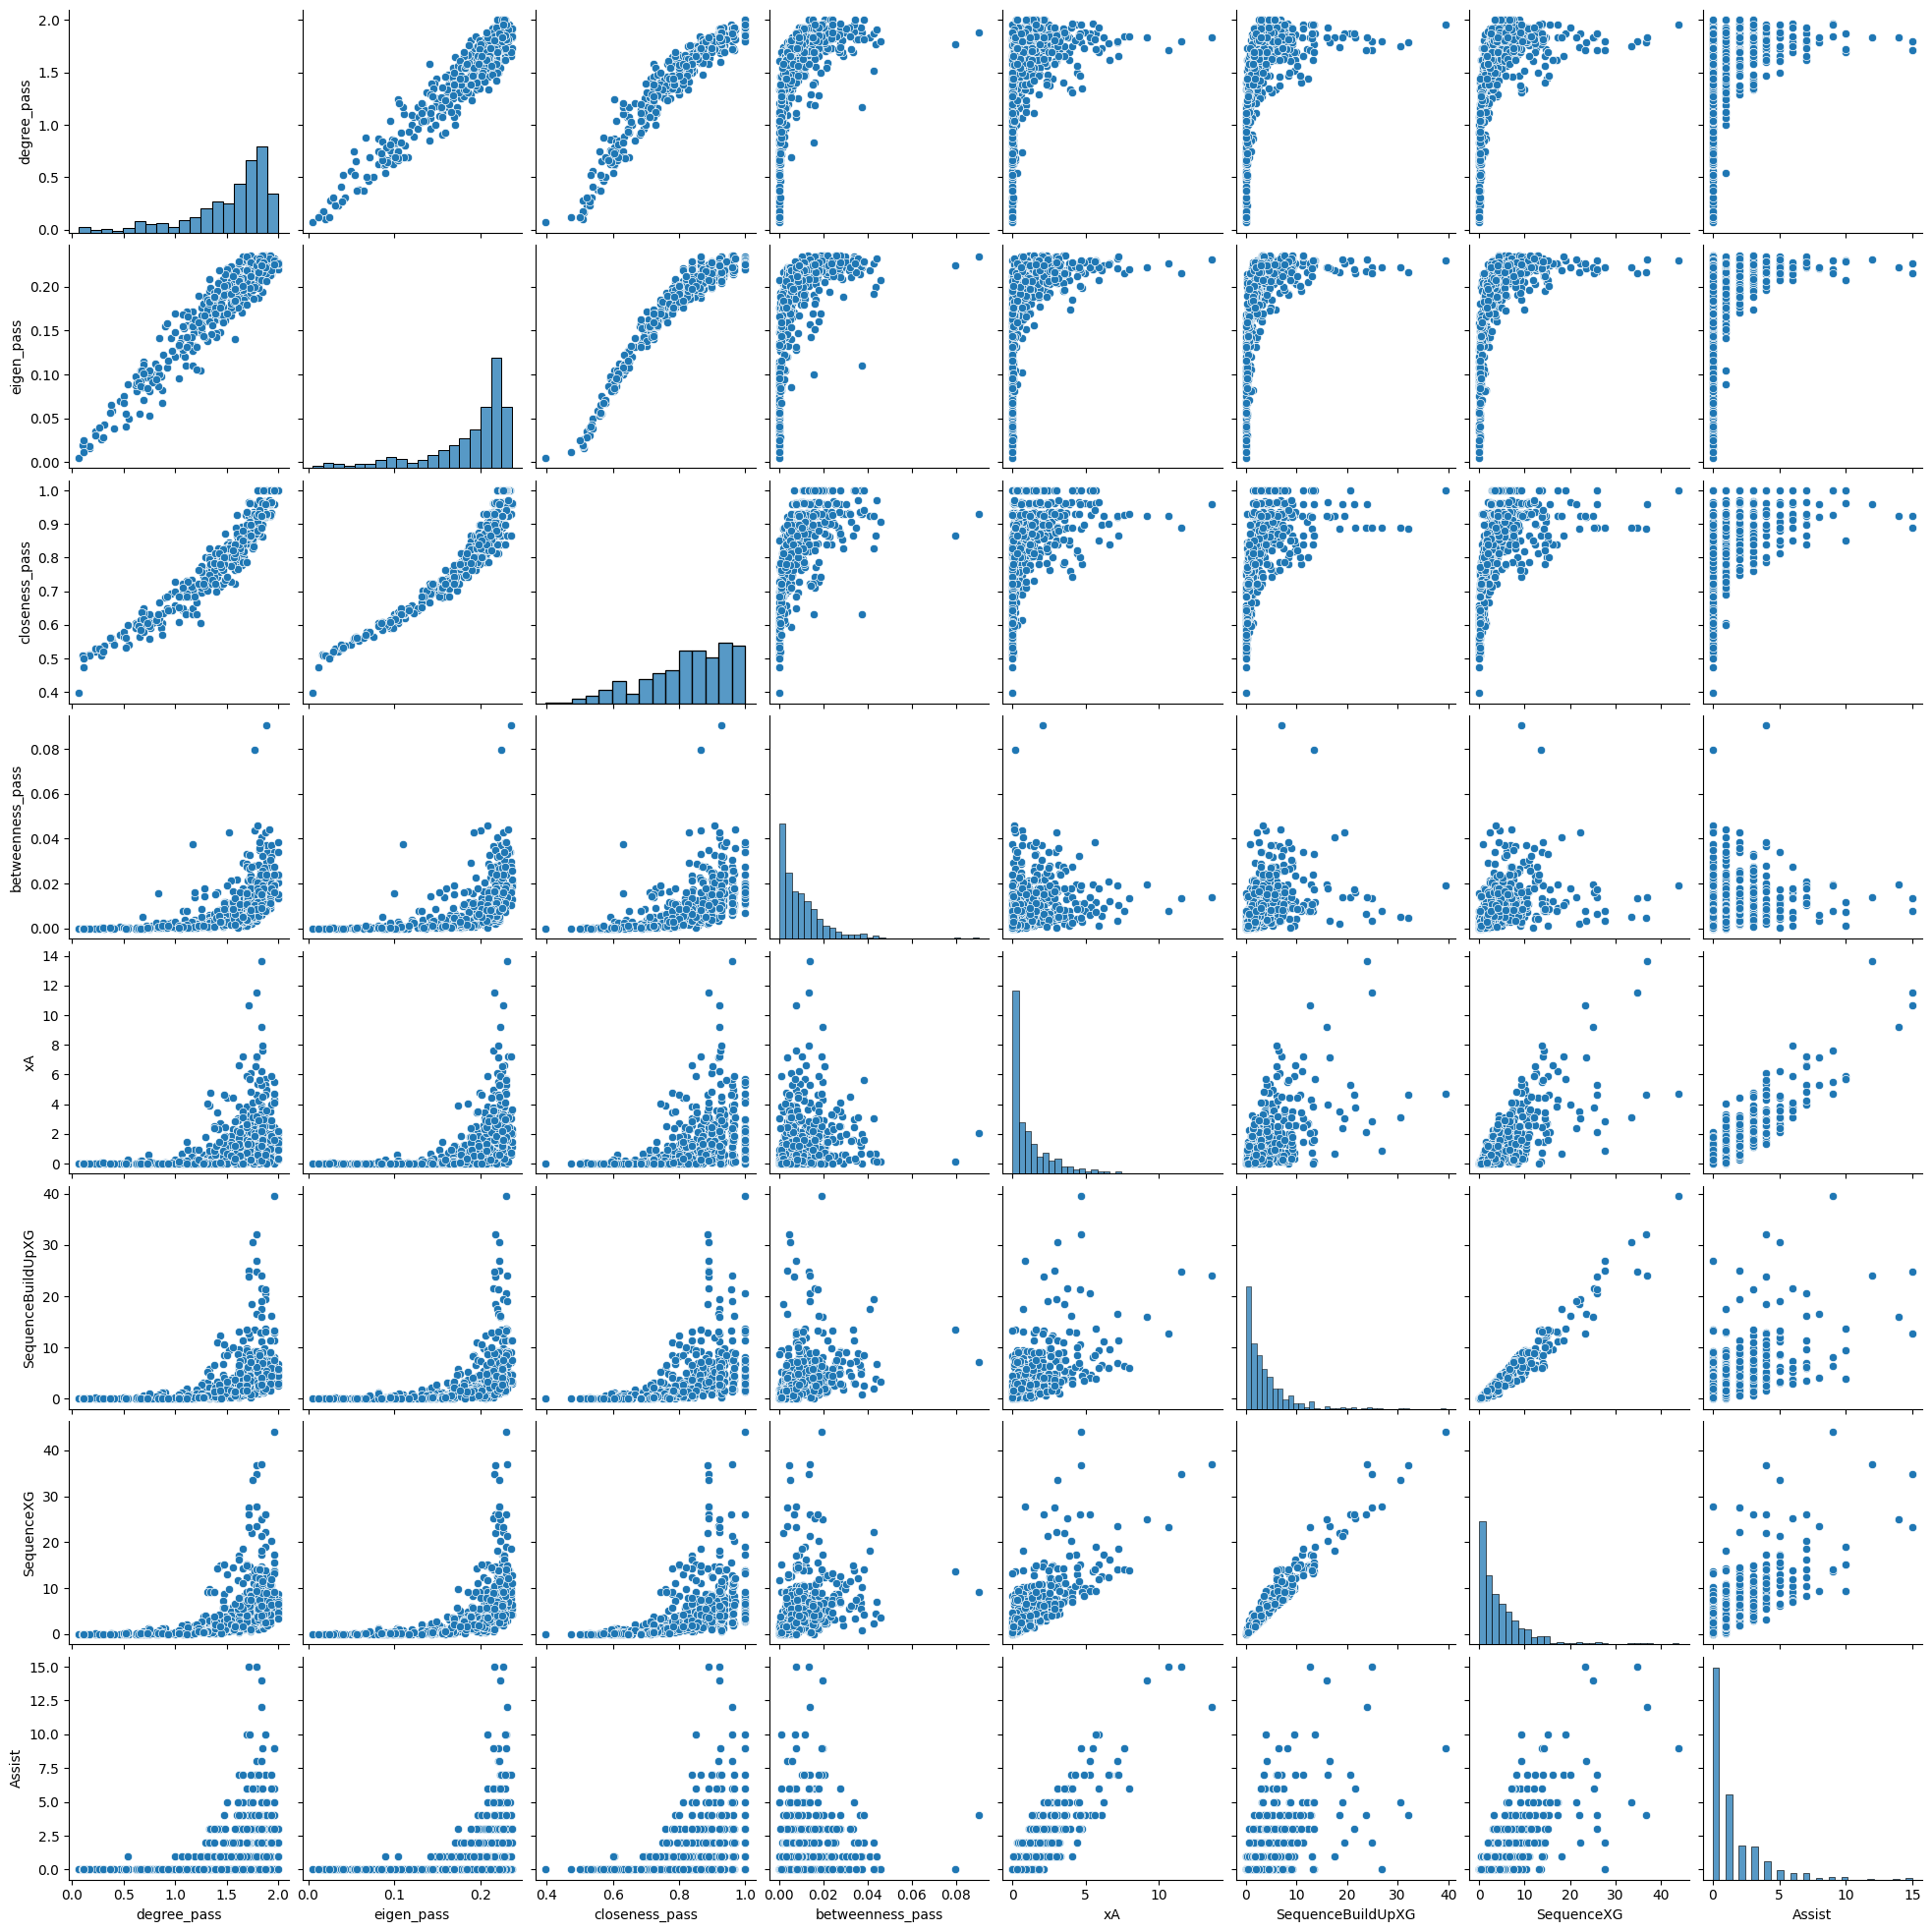

In [15]:
sns.pairplot(by_player_pass)

Positive skewed columns:'betweenness_pass', 'xA', 'SequenceBuildUpXG', 'SequenceXG', 'Assist' 

negative skewed columns:'degree_pass', 'eigen_pass', 'closeness_pass'

In [16]:
to_log_col = ['betweenness_pass', 'xA', 'SequenceBuildUpXG', 'SequenceXG', 'Assist']
to_neg_log_col = ['degree_pass', 'eigen_pass', 'closeness_pass']

In [17]:
transformed_pass = by_player_pass.copy()


# Log transform for positive-skewed columns
for col in ['betweenness_pass','xA', 'SequenceBuildUpXG', 'SequenceXG', 'Assist']:
    transformed_pass[col] = np.log(transformed_pass[col] + 0.000001)  # +1 to handle zero values


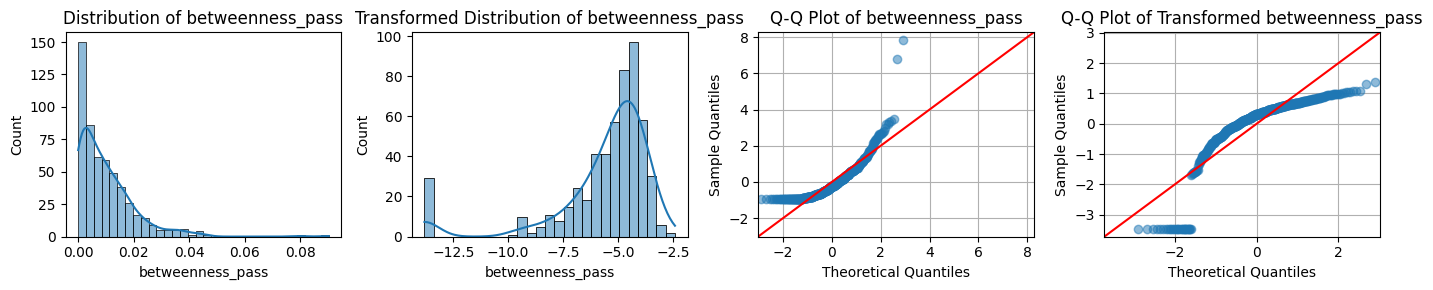

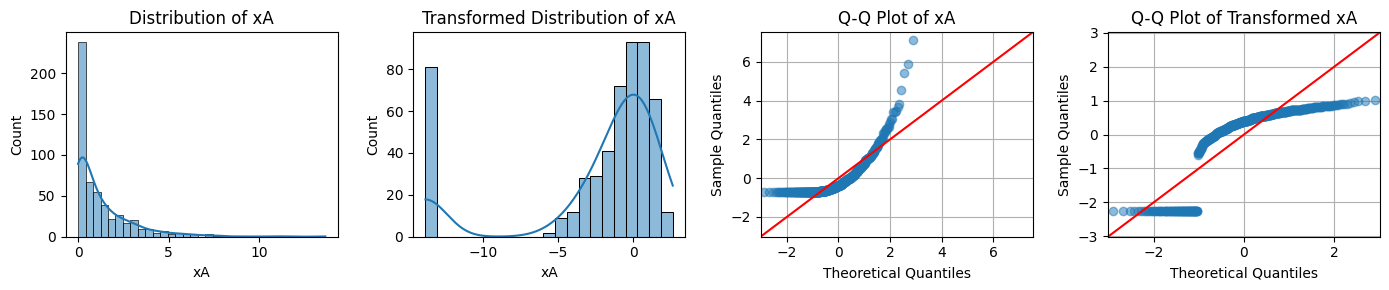

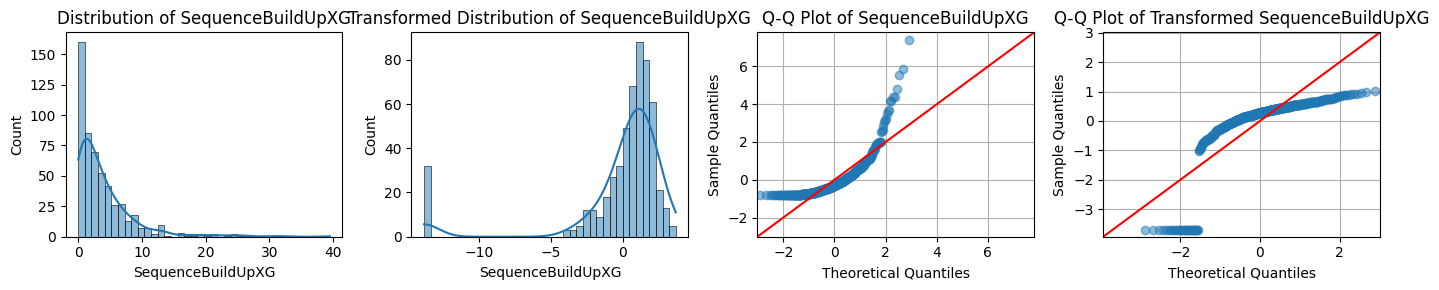

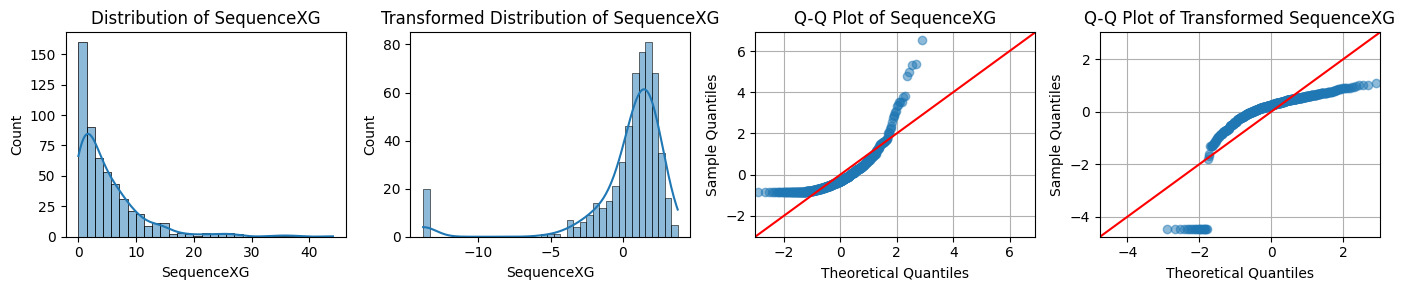

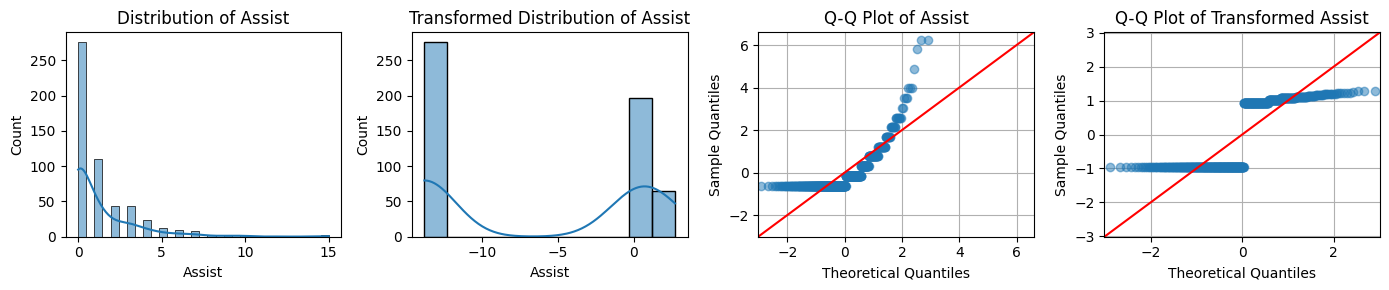

In [18]:

import statsmodels.api as sm

numerical_cols = transformed_pass.select_dtypes(include=['int64', 'float64']).columns
# Loop through numerical columns
for col in ['betweenness_pass' ,'xA', 'SequenceBuildUpXG', 'SequenceXG', 'Assist']:
    
    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 4, figsize=(14, 3))
    # Plot 1: Distribution Plot
    sns.histplot(by_player_pass[col], kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of {col}")
    axes[0].set_xlabel(col)
    # Plot 1: Distribution Plot
    sns.histplot(transformed_pass[col], kde=True, ax=axes[1])
    axes[1].set_title(f"Transformed Distribution of {col}")
    axes[1].set_xlabel(col)


    # Plot 2: Q-Q Plot with Confidence Intervals
    sm.qqplot(by_player_pass[col], line='45', alpha=0.5, fit=True, ax=axes[2])
    axes[2].set_title(f"Q-Q Plot of {col}")
    axes[2].grid(True)


    # Plot 2: Q-Q Plot with Confidence Intervals
    sm.qqplot(transformed_pass[col], line='45', alpha=0.5, fit=True, ax=axes[3])
    axes[3].set_title(f"Q-Q Plot of Transformed {col}")
    axes[3].grid(True)


    # Adjust layout and show plots
    plt.tight_layout()
    plt.show()

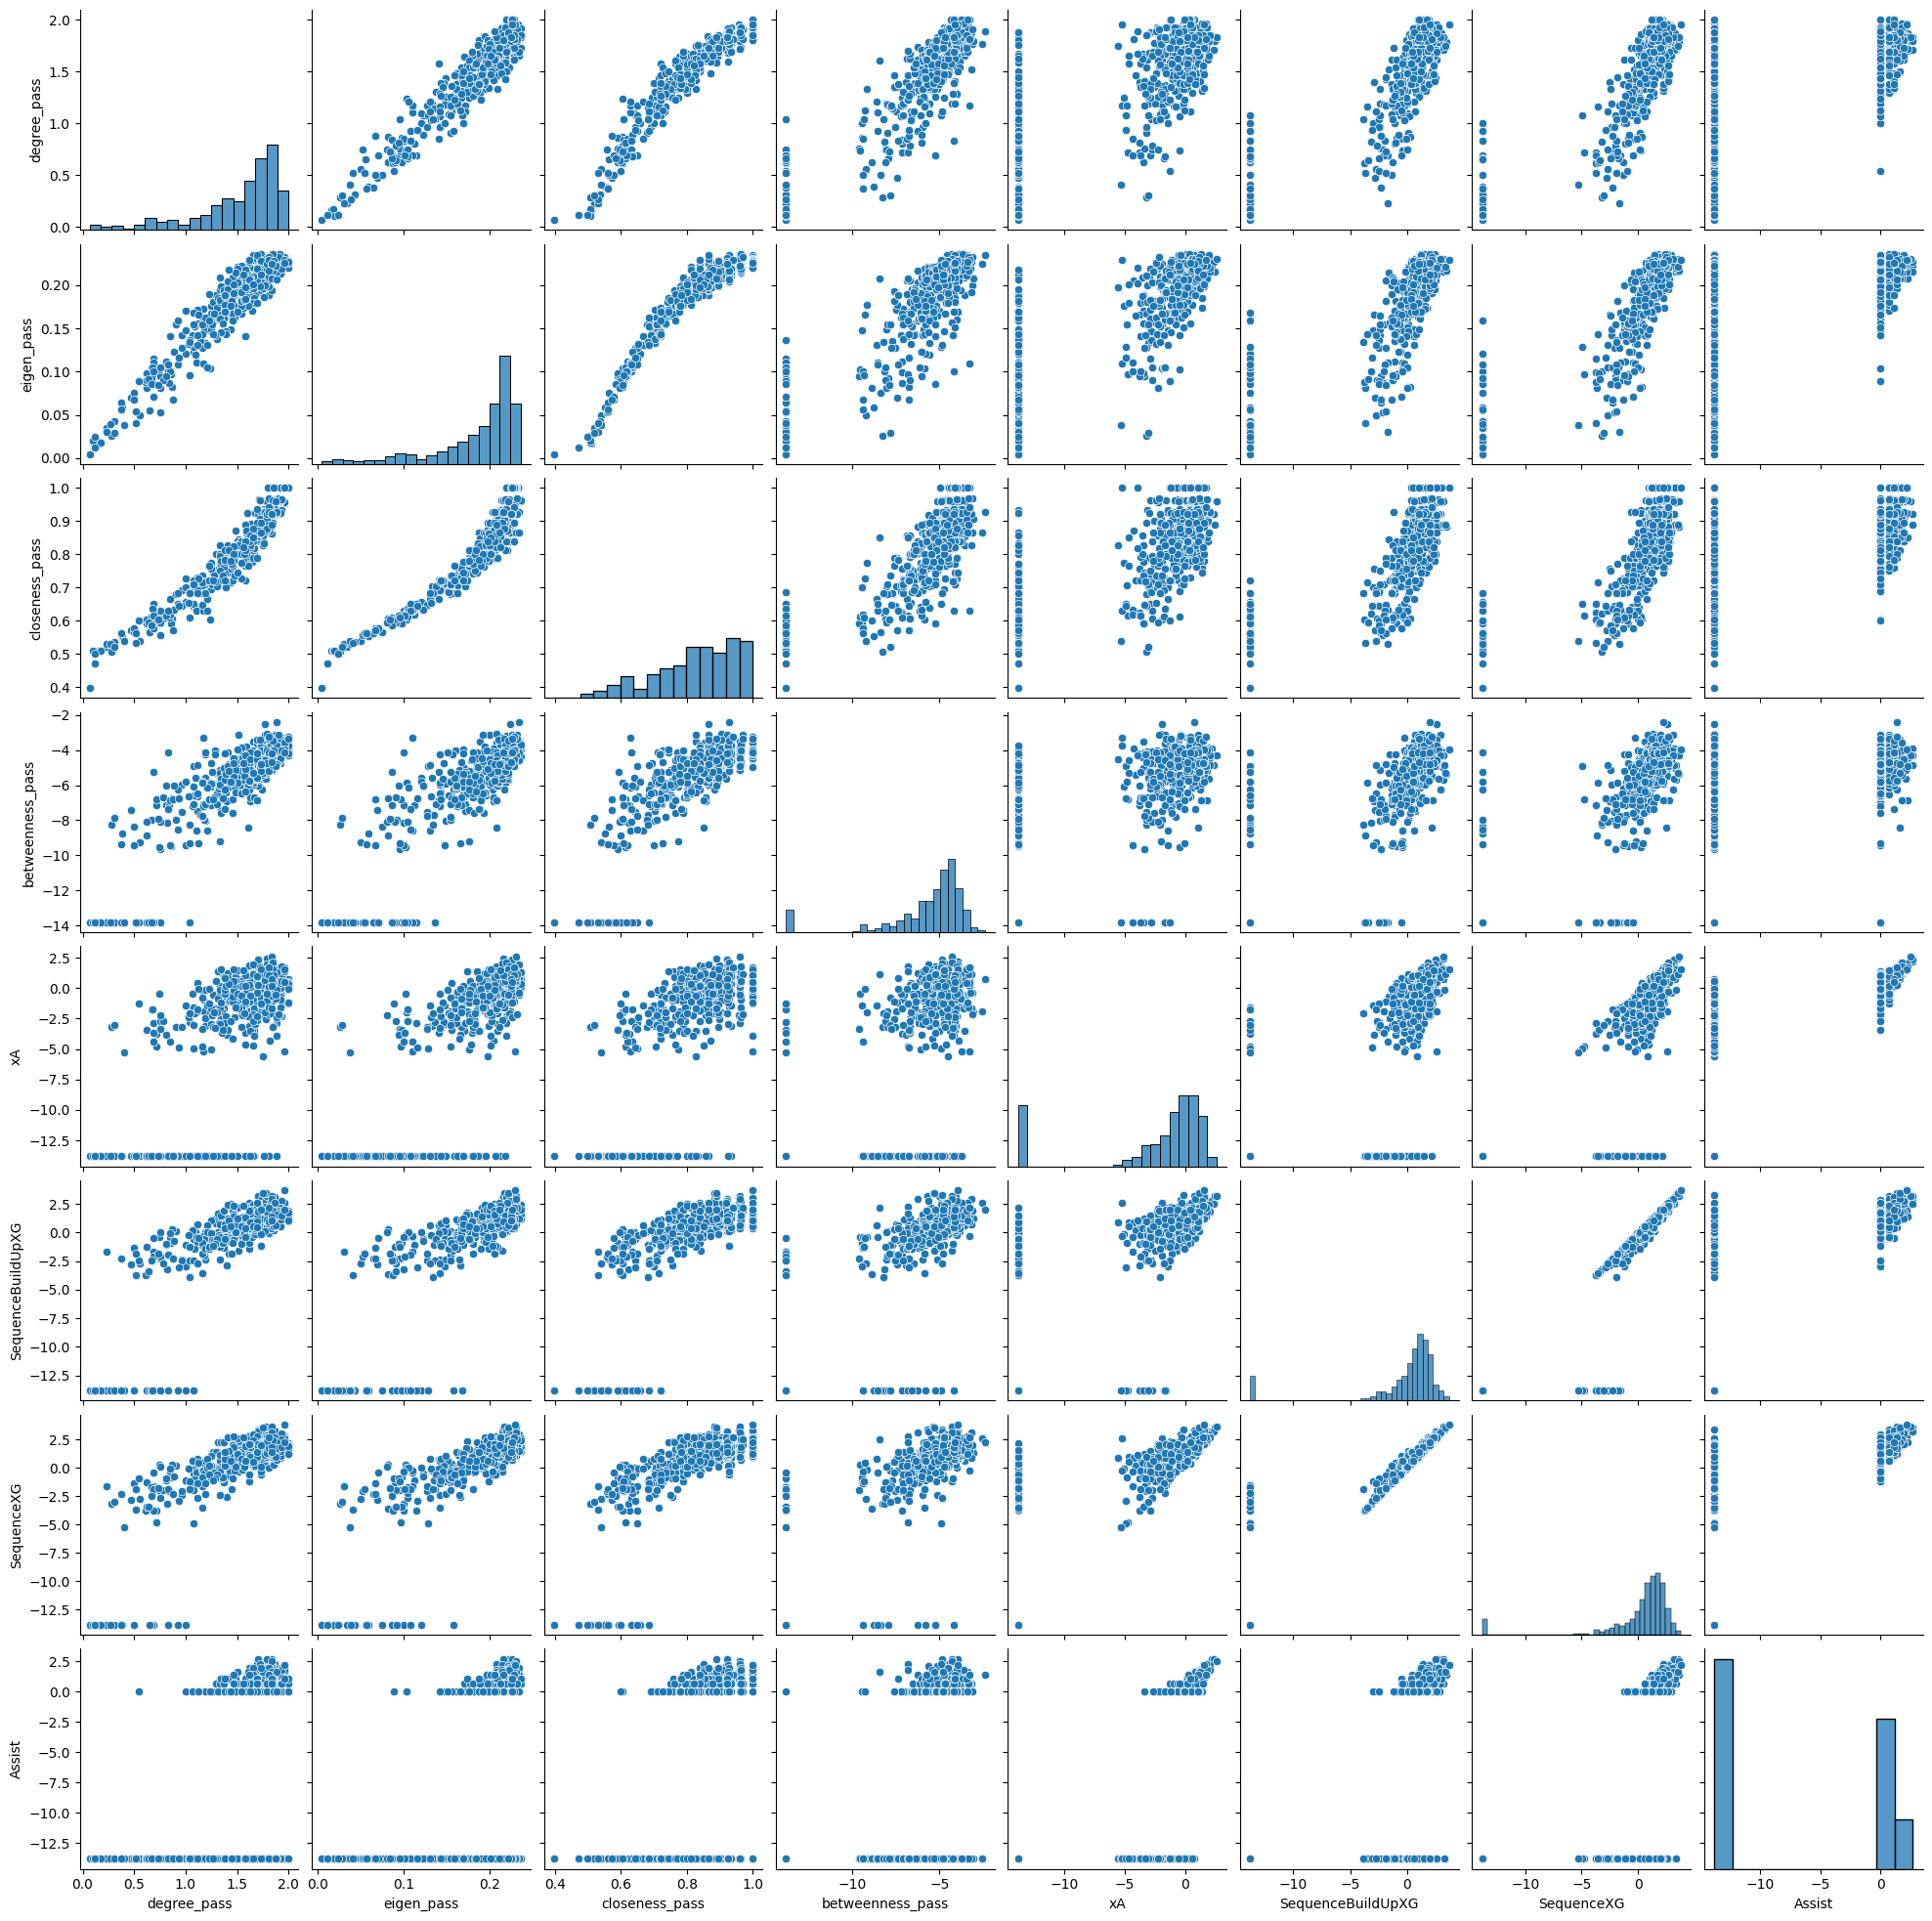

In [19]:
# Pairplot for numerical columns
sns.pairplot(transformed_pass[numerical_cols])
plt.show()


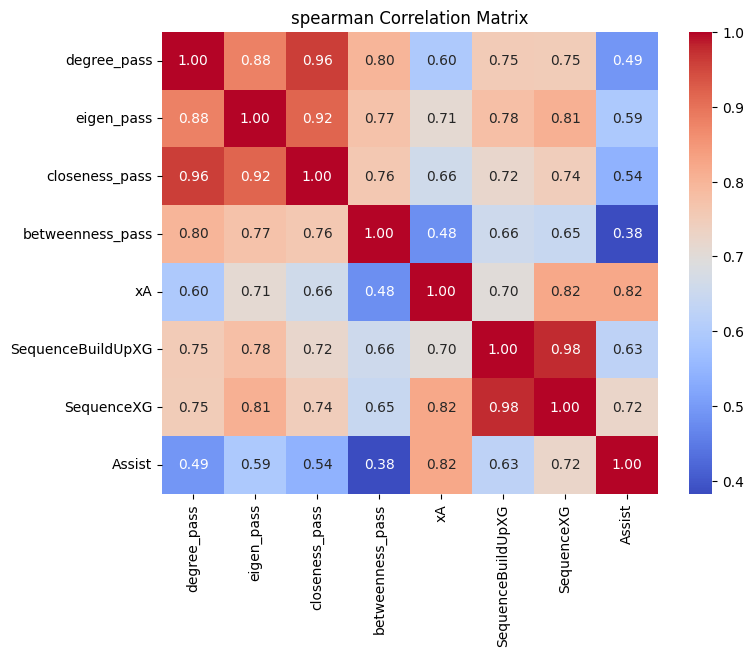

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(transformed_pass[numerical_cols].corr(method="spearman"), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("spearman Correlation Matrix")
plt.show()

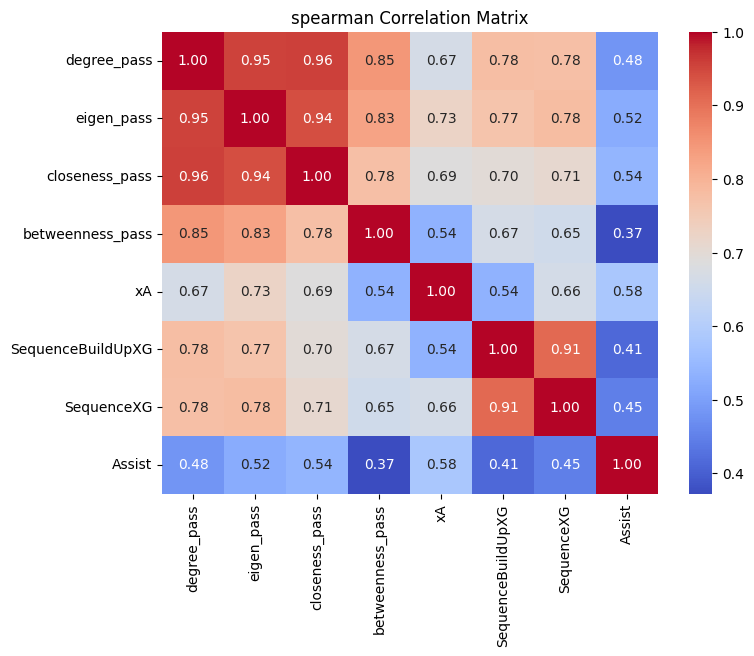

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(transformed_pass[numerical_cols].corr(method="pearson"), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("spearman Correlation Matrix")
plt.show()

In [22]:
def scatter_linear(x, y):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.optimize import curve_fit

    # Define the linear function
    def linear_func(x, a, b):
        return a * x + b

    # Fit the linear model to the data
    x_data = x
    y_data = y
    popt, pcov = curve_fit(linear_func, x_data, y_data)  # popt contains [a, b]

    # Extract the coefficients and their uncertainties
    a_fit, b_fit = popt
    perr = np.sqrt(np.diag(pcov))  # Standard deviation of the parameters
    a_err, b_err = perr

    print(f"Fitted Parameters: a = {a_fit:.2f} ± {a_err:.2f}, b = {b_fit:.2f} ± {b_err:.2f}")

    # Generate fitted values
    x_fit = np.linspace(x_data.min(), x_data.max(), 100)
    y_fit = linear_func(x_fit, a_fit, b_fit)

    # Calculate prediction intervals
    n = len(y_data)  # Number of data points
    p = len(popt)    # Number of parameters
    alpha = 0.05     # 95% confidence level
    dof = max(0, n - p)  # Degrees of freedom
    t_val = 1.96     # For 95% confidence level (approximation)

    # Residuals
    residuals = y_data - linear_func(x_data, *popt)
    std_err = np.sqrt(np.sum(residuals**2) / dof)

    # Prediction interval bounds
    ci_upper = y_fit + t_val * std_err
    ci_lower = y_fit - t_val * std_err
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # Plot the data, fit, and confidence bands
    axes[0].scatter(x_data, y_data, label='Data Points', color='blue', alpha=0.5)  # Corrected
    axes[0].plot(x_fit, y_fit, label=f'Linear Fit: y = {a_fit:.2f} * x + {b_fit:.2f}', color='red')
    axes[0].fill_between(x_fit, ci_lower, ci_upper, color='red', alpha=0.2, label='95% Prediction Interval')
    axes[0].set_title("Linear Fit with Prediction Interval")
    axes[0].set_xlabel(x.name if hasattr(x, 'name') else 'X')
    axes[0].set_ylabel(y.name if hasattr(y, 'name') else 'Y')
    axes[0].legend()

    # Plot the residuals
    sns.histplot(residuals, kde=True, ax=axes[1])
    axes[1].set_title("Distribution of Residuals")
    axes[1].set_xlabel('Residuals')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()



def scatter_exp(x, y):    # Define the exponential function
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.optimize import curve_fit

    def exponential_func(x, a, b):
        return a * np.exp(b * x)

    # Fit the exponential model to the data
    x_data = x
    y_data = y
    popt, pcov = curve_fit(exponential_func, x_data, y_data)  # popt contains [a, b]

    # Extract the coefficients and their uncertainties
    a_fit, b_fit = popt
    perr = np.sqrt(np.diag(pcov))  # Standard deviation of the parameters
    a_err, b_err = perr

    print(f"Fitted Parameters: a = {a_fit:.2f} ± {a_err:.2f}, b = {b_fit:.2f} ± {b_err:.2f}")
    
    # Generate fitted values
    x_fit = np.linspace(x_data.min(), x_data.max(), 100)
    y_fit = exponential_func(x_fit, a_fit, b_fit)

    # Calculate prediction intervals
    n = len(y_data)  # Number of data points
    p = len(popt)    # Number of parameters
    alpha = 0.05     # 95% confidence level
    dof = max(0, n - p)  # Degrees of freedom
    t_val = 1.96     # For 95% confidence level (approximation)

    # Residuals
    residuals = y_data - exponential_func(x_data, *popt)
    std_err = np.sqrt(np.sum(residuals**2) / dof)

    # Prediction interval bounds
    ci_upper = y_fit + t_val * std_err
    ci_lower = y_fit - t_val * std_err

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # Residual plot
    sns.histplot(residuals, kde=True, ax=axes[1])
    axes[1].set_title("Distribution of Residuals")
    axes[1].set_xlabel('Residuals')
    
    # Data and fit plot
    axes[0].scatter(x_data, y_data, label='Data Points', color='blue', alpha=0.5)  # Corrected
    axes[0].plot(x_fit, y_fit, label=f'Exponential Fit: y = {a_fit:.2f} * exp({b_fit:.2f} * x)', color='red')
    axes[0].fill_between(x_fit, ci_lower, ci_upper, color='red', alpha=0.2, label='95% Prediction Interval')
    axes[0].set_title("Exponential Fit with Prediction Interval")
    axes[0].set_xlabel(x.name if hasattr(x, 'name') else 'X')
    axes[0].set_ylabel(y.name if hasattr(y, 'name') else 'Y')
    axes[0].legend()

    # Adjust layout and show
    plt.tight_layout()
    plt.show()


In [23]:
transformed_pass.columns

Index(['player', 'degree_pass', 'eigen_pass', 'closeness_pass',
       'betweenness_pass', 'xA', 'SequenceBuildUpXG', 'SequenceXG', 'Assist'],
      dtype='object')

In [24]:
transformed_pass['eigen_pass'].name

'eigen_pass'

Fitted Parameters: a = 50.22 ± 1.73, b = -8.95 ± 0.33


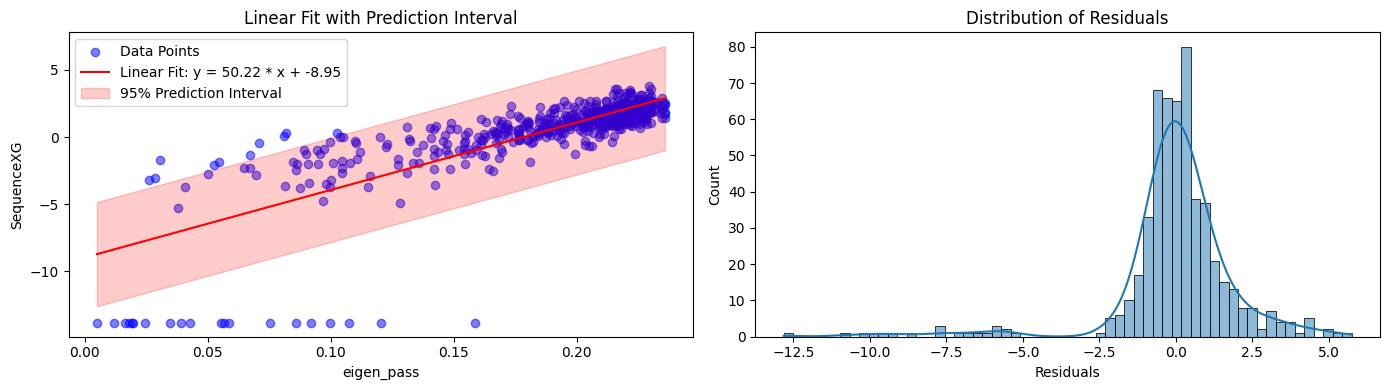

In [25]:
scatter_linear(transformed_pass['eigen_pass'], transformed_pass['SequenceXG'])

Fitted Parameters: a = 0.01 ± 0.01, b = 30.29 ± 2.91


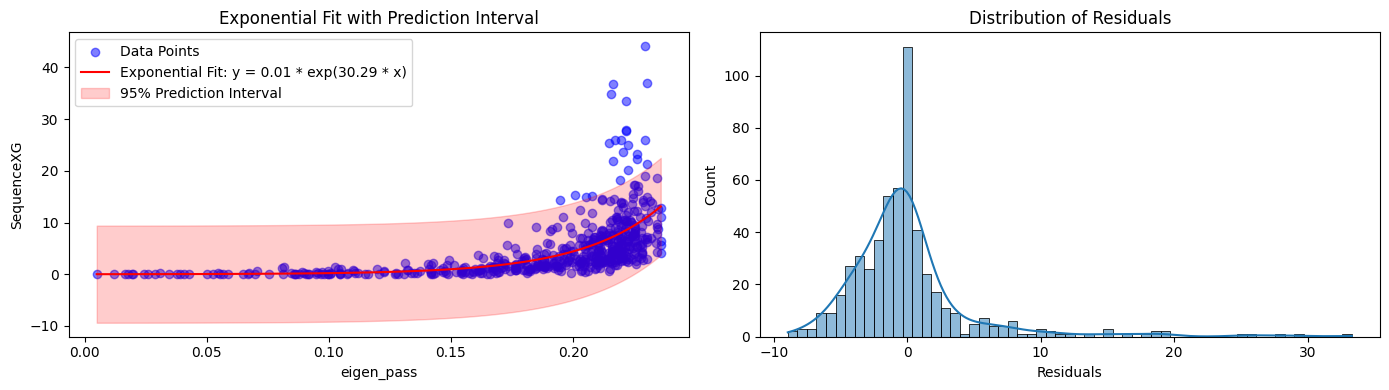

In [26]:
scatter_exp(by_player_pass['eigen_pass'], by_player_pass['SequenceXG'])

In [15]:
by_player_pass.to_excel('players_pass_data.xlsx', index=False, sheet_name='Stats')

 ### **Görselleştirme**

In [28]:

team_name = "Barcelona"  # Replace with the desired team name

team_graphs[team_name].nodes(data=True)

NodeDataView({'Neymar da Silva Santos Junior': {}, 'Luis Alberto Suárez Díaz': {}, 'Sergio Busquets i Burgos': {}, 'Andrés Iniesta Luján': {}, 'Jérémy Mathieu': {}, 'Gerard Piqué Bernabéu': {}, 'Jordi Alba Ramos': {}, 'Daniel Alves da Silva': {}, 'Sergi Roberto Carnicer': {}, 'Munir El Haddadi Mohamed': {}, 'Claudio Andrés Bravo Muñoz': {}, 'Marc Bartra Aregall': {}, 'Sandro Ramírez Castillo': {}, 'Javier Alejandro Mascherano': {}, 'Ivan Rakitić': {}, 'Douglas Pereira dos Santos': {}, 'Gerard Gumbau Garriga': {}, 'Aleix Vidal Parreu': {}, 'Arda Turan': {}, 'Lionel Andrés Messi Cuccittini': {}, 'Sergi Samper Montaña': {}, 'Thomas Vermaelen': {}, 'Marc-André ter Stegen': {}, 'Adriano Correia Claro': {}, 'Rafael Alcântara do Nascimento': {}})

In [29]:
def assign_properties(g):
    # Centrality calculation
    node_centralities = nx.degree_centrality(g)

    # Graph properties
    g.graph['node_border_size'] = 1.5
    g.graph['node_border_color'] = 'white'
    g.graph['edge_opacity'] = 0.9

    # Node properties: Size by centrality, shape by size, color by community
    for node_id in g.nodes:
        node = g.nodes[node_id]
        node['size'] = 10 + node_centralities[node_id] * 100
        print(node)

    # Edge properties: Size by centrality, color by community (within=community color, between=black)
    for edge_id in g.edges(data=True):
        edge = g.nodes[edge_id]
        source, target, attrs = edge
        weight = attrs.get('weight', None)
        edge['size'] = weight * 0.5


In [30]:
g = team_graphs[team_name].copy()

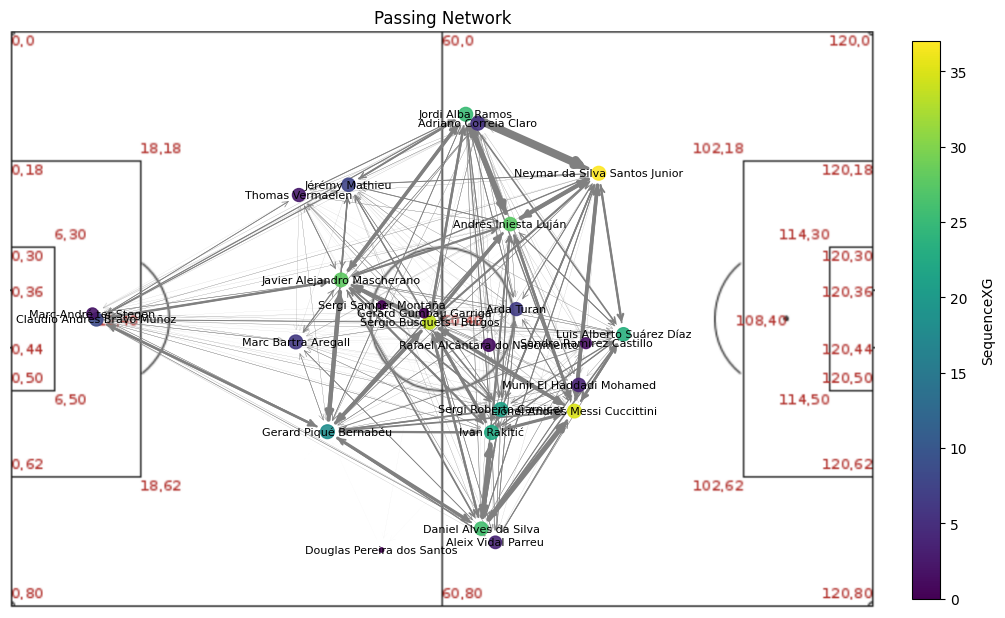

In [31]:
network_viz(season_network_DF,season_network)

In [32]:

def network_viz_filtered(df, G, centrality_threshold=0.1, edge_weight_threshold=5):
    # Compute player positions
    pass_positions = df[['player', 'x', 'y']].rename(columns={'x': 'pos_x', 'y': 'pos_y'})
    receive_positions = df[['pass_recipient', 'pass_end_x', 'pass_end_y']].rename(
        columns={'pass_recipient': 'player', 'pass_end_x': 'pos_x', 'pass_end_y': 'pos_y'}
    )

    # Combine pass and receive positions
    all_positions = pd.concat([pass_positions, receive_positions], ignore_index=True)

    # Calculate average positions
    average_positions_df = all_positions.groupby('player')[['pos_x', 'pos_y']].mean()

    # Filter edges by weight
    edges_to_keep = [
        (source, target) for source, target, data in G.edges(data=True) if data.get('weight', 0) >= edge_weight_threshold
    ]

    # Create a subgraph with filtered edges
    G_filtered = G.edge_subgraph(edges_to_keep).copy()

    # Filter nodes by centrality
    centrality = nx.degree_centrality(G_filtered)
    nodes_to_keep = [node for node, value in centrality.items() if value >= centrality_threshold]
    G_filtered = G_filtered.subgraph(nodes_to_keep).copy()

    # Remove isolated nodes if needed
    G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

    # Update average positions for filtered nodes
    average_positions = {
        node: (average_positions_df.loc[node]['pos_x'], average_positions_df.loc[node]['pos_y'])
        for node in G_filtered.nodes if node in average_positions_df.index
    }

    # Node size and color calculations
    min_size, max_size = 10, 200  # Desired size range
    min_centrality = min(centrality.values(), default=0)
    max_centrality = max(centrality.values(), default=1)

    node_sizes = [
        min_size + ((centrality[node] - min_centrality) / (max_centrality - min_centrality)) * (max_size - min_size)
        for node in G_filtered.nodes
    ]

    grouped = df.groupby('player')['SequenceXG'].sum().reset_index()
    grouped.set_index('player', inplace=True)
    norm = mcolors.Normalize(vmin=grouped['SequenceXG'].min(), vmax=grouped['SequenceXG'].max())
    colormap = cm.viridis
    node_colors = [
        mcolors.to_hex(colormap(norm(grouped.loc[node]['SequenceXG']))) if node in grouped.index else '#808080'
        for node in G_filtered.nodes
    ]

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 8))

    # Add background field image
    try:
        field_image = plt.imread("pitch.png")  # Path to the football field image
        ax.imshow(field_image, extent=[0, 120, 80, 0], zorder=0)  # Adjust to field dimensions
    except FileNotFoundError:
        print("Field image not found. Please ensure 'pitch.png' is in the correct path.")

    # Draw nodes and edges
    nx.draw_networkx_nodes(G_filtered, average_positions, node_size=node_sizes, node_color=node_colors, ax=ax, alpha=0.9)
    nx.draw_networkx_labels(G_filtered, average_positions, font_size=8, font_color="black", ax=ax)
    nx.draw_networkx_edges(
        G_filtered,
        average_positions,
        edge_color="gray",
        width=[data['weight'] * 0.01 for _, _, data in G_filtered.edges(data=True)],
        arrowstyle='->',
        arrowsize=10,
        ax=ax
    )

    # Add colorbar for node colors
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('SequenceXG', rotation=90, labelpad=10)

    # Axis settings
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 80)
    ax.set_axis_off()  # Hide axes
    ax.invert_yaxis()  # Invert y-axis to match football field orientation

    plt.title("Filtered Passing Network")
    plt.show()

def visualize_thresholds(G):
    # Compute centrality and edge weights
    centrality = nx.degree_centrality(G)
    edge_weights = [data.get('weight', 0) for _, _, data in G.edges(data=True)]

    # Convert centrality and edge weights to DataFrame for visualization
    centrality_df = pd.DataFrame({'Node': list(centrality.keys()), 'Centrality': list(centrality.values())})
    edge_weights_df = pd.DataFrame({'Edge': [f"{u}->{v}" for u, v, _ in G.edges(data=True)], 'Weight': edge_weights})

    # Plot centrality distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(centrality_df['Centrality'], bins=50, color='skyblue', edgecolor='black')
    plt.title("Centrality Distribution")
    plt.xlabel("Centrality Value")
    plt.ylabel("Frequency")

    # Plot edge weight distribution
    plt.subplot(1, 2, 2)
    plt.hist(edge_weights_df['Weight'], bins=50, color='salmon', edgecolor='black')
    plt.title("Edge Weight Distribution")
    plt.xlabel("Edge Weight")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

    # Print statistics for better threshold decisions
    print("Centrality Stats:")
    print(centrality_df['Centrality'].describe())
    print("\nEdge Weight Stats:")
    print(edge_weights_df['Weight'].describe())



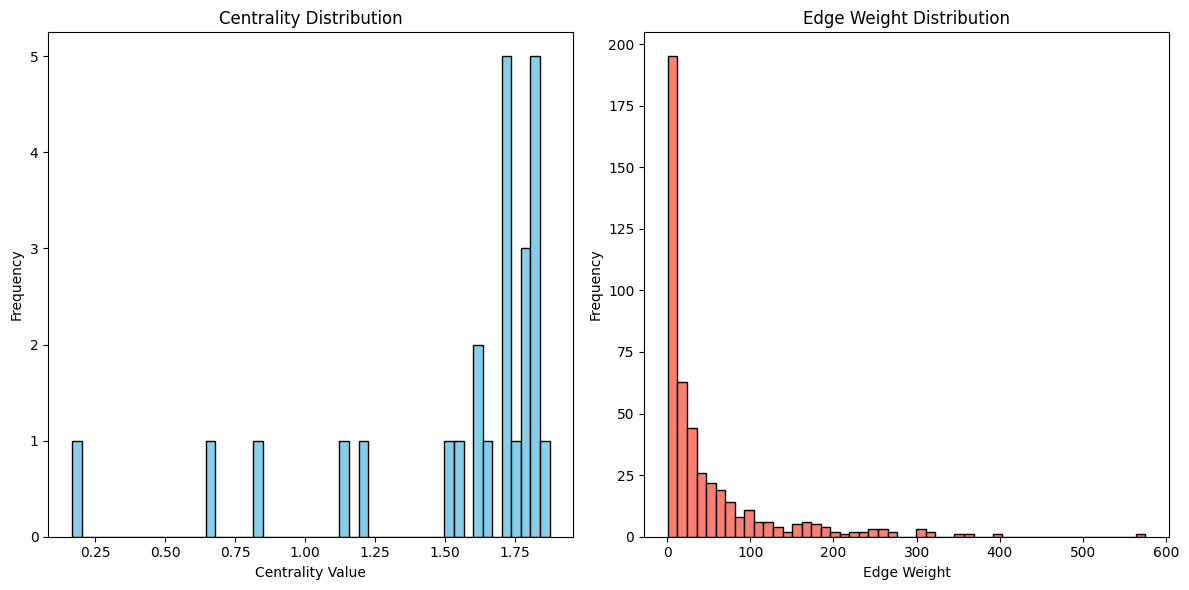

Centrality Stats:
count    25.000000
mean      1.546667
std       0.427180
min       0.166667
25%       1.541667
50%       1.708333
75%       1.791667
max       1.875000
Name: Centrality, dtype: float64

Edge Weight Stats:
count    464.000000
mean      47.698276
std       72.279691
min        1.000000
25%        5.000000
50%       18.000000
75%       58.000000
max      575.000000
Name: Weight, dtype: float64


In [33]:
visualize_thresholds(season_network)

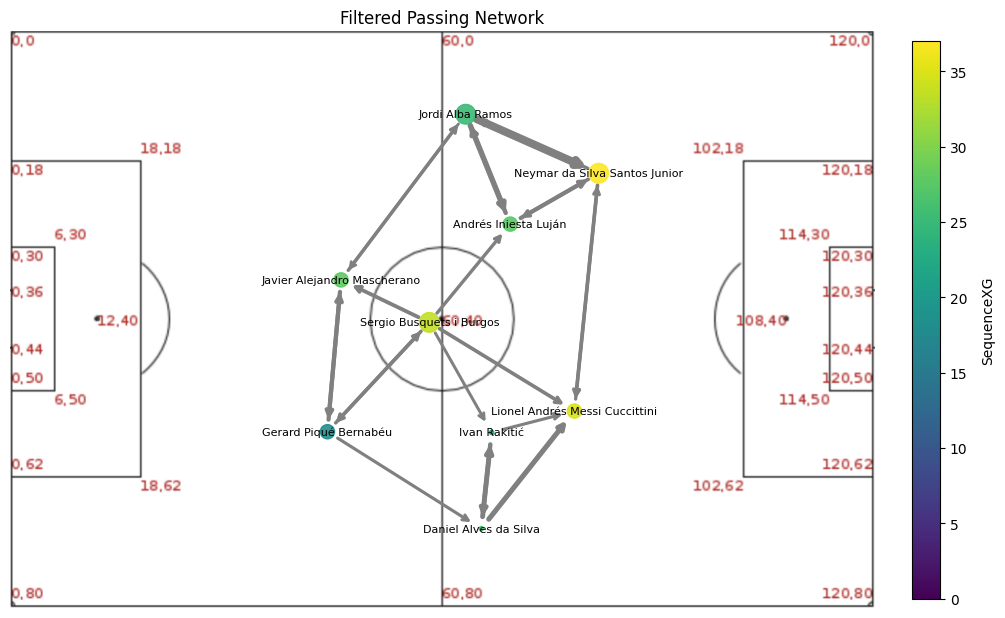

In [34]:
network_viz_filtered(season_network_DF,season_network,edge_weight_threshold=200)

In [35]:
season_network_DF.shape


(22132, 37)

In [36]:
season_network_DF[season_network_DF["player"]=="Francisco Medina Luna"]["team"].unique()

array([], dtype=object)

In [37]:

gv.d3(season_network)


### Shot Network

seq type çalışmıyo onu düzelt

In [38]:
all_teams_dataframe[['player','pass_succes','pass_recipient','player_shotFromPass',
       'shot_type_shotFromPass', 'shot_outcome_shotFromPass',
       'shot_statsbomb_xg_shotFromPass', 'SequenceXG', 'SequenceBuildUpXG',
       'pass_succes', 'SequenceType']]

player  pass_succes            pass_recipient  \
0        Adrián González Morales         True      Borja González Tomás   
1           Borja González Tomás         True    Daniel García Carrillo   
2         Daniel García Carrillo         True         Aleksandar Pantić   
3              Aleksandar Pantić         True   Mauro Javier Dos Santos   
4        Mauro Javier Dos Santos         True         Aleksandar Pantić   
...                          ...          ...                       ...   
276758              Ivan Rakitić         True  Sergio Busquets i Burgos   
276759  Sergio Busquets i Burgos         True          Jordi Alba Ramos   
276760          Jordi Alba Ramos         True      Andrés Iniesta Luján   
276761  Luis Alberto Suárez Díaz         True  Sergio Busquets i Burgos   
276762  Sergio Busquets i Burgos         True          Jordi Alba Ramos   

       player_shotFromPass shot_type_shotFromPass shot_outcome_shotFromPass  \
0                     None                   None                      None   
1                     None                   None                      None   
2                     None                   None                      None   
3                     None                   None                      None   
4                     None                   None                      None   
...                    ...                    ...                       ...   
276758                None                   None                      None   
276759                None                   None                      None   
276760                None                   None                      None   
276761                None                   None                      None   
276762                None                   None                      None   

        shot_statsbomb_xg_shotFromPass  SequenceXG  SequenceBuildUpXG  \
0                                  NaN         0.0                0.0   
1                                  NaN         0.0                0.0   
2                                  NaN         0.0                0.0   
3                                  NaN         0.0                0.0   
4                                  NaN         0.0                0.0   
...                                ...         ...                ...   
276758                             NaN         0.0                0.0   
276759                             NaN         0.0                0.0   
276760                             NaN         0.0                0.0   
276761                             NaN         0.0                0.0   
276762                             NaN         0.0                0.0   

        pass_succes SequenceType  
0              True       NoShot  
1              True       NoShot  
2              True       NoShot  
3              True       NoShot  
4              True       NoShot  
...             ...          ...  
276758         True       NoShot  
276759         True       NoShot  
276760         True       NoShot  
276761         True       NoShot  
276762         True       NoShot  

[276763 rows x 11 columns]

In [39]:
all_teams_dataframe['SequenceType'].unique()

array(['NoShot', 'Goal', 'Shot'], dtype=object)

In [40]:
goal_pdf = all_teams_dataframe[all_teams_dataframe['SequenceType']=='Goal'][["player",'team',"match_id",'pass_succes','pass_recipient',"degree_c", "eigen_c", "closeness_c", "betweenness_c",'shot_outcome_shotFromPass',"shot_statsbomb_xg_shotFromPass","SequenceBuildUpXG", 'SequenceXG' ]]
goal_pdf.rename(columns={'degree_c':'overall_degree_c','eigen_c':'overall_eigen_c','closeness_c':'overall_closeness_c','betweenness_c':'overall_betweenness_c'},inplace=True)
goal_pdf

player       team  match_id  pass_succes  \
26                   Gonzalo Escalante      Eibar   3825848         True   
27             Adrián González Morales      Eibar   3825848         True   
28              Sergio Gontán Gallardo      Eibar   3825848         True   
29             Adrián González Morales      Eibar   3825848         True   
30             Mauro Javier Dos Santos      Eibar   3825848         True   
...                                ...        ...       ...          ...   
276614          Sergi Roberto Carnicer  Barcelona    266557         True   
276615                    Ivan Rakitić  Barcelona    266557         True   
276616  Lionel Andrés Messi Cuccittini  Barcelona    266557         True   
276617   Neymar da Silva Santos Junior  Barcelona    266557         True   
276618                Jordi Alba Ramos  Barcelona    266557         True   

                        pass_recipient  overall_degree_c  overall_eigen_c  \
26             Adrián González Morales          1.769231         0.228300   
27              Sergio Gontán Gallardo          1.846154         0.229477   
28             Adrián González Morales          1.846154         0.235909   
29             Mauro Javier Dos Santos          1.846154         0.229477   
30                Borja González Tomás          1.846154         0.227825   
...                                ...               ...              ...   
276614                    Ivan Rakitić          1.833333         0.230461   
276615  Lionel Andrés Messi Cuccittini          1.875000         0.226338   
276616   Neymar da Silva Santos Junior          1.791667         0.215763   
276617                Jordi Alba Ramos          1.833333         0.230461   
276618  Lionel Andrés Messi Cuccittini          1.833333         0.214830   

        overall_closeness_c  overall_betweenness_c shot_outcome_shotFromPass  \
26                 0.896552               0.014267                   Blocked   
27                 0.928571               0.037141                      None   
28                 0.962963               0.025655                      None   
29                 0.928571               0.037141                      None   
30                 0.896552               0.024964                      Goal   
...                     ...                    ...                       ...   
276614             0.960000               0.013850                      None   
276615             0.923077               0.042719                      None   
276616             0.888889               0.013581                      None   
276617             0.960000               0.013850                      None   
276618             0.888889               0.016070                      Goal   

        shot_statsbomb_xg_shotFromPass  SequenceBuildUpXG  SequenceXG  
26                            0.034535           0.394774    0.394774  
27                                 NaN           0.394774    0.394774  
28                                 NaN           0.394774    0.394774  
29                                 NaN           0.394774    0.394774  
30                            0.394774           0.000000    0.394774  
...                                ...                ...         ...  
276614                             NaN           0.101879    0.101879  
276615                             NaN           0.101879    0.101879  
276616                             NaN           0.101879    0.101879  
276617                             NaN           0.101879    0.101879  
276618                        0.101879           0.000000    0.101879  

[3134 rows x 13 columns]

In [41]:
# Dictionaries to store data
#team_graphs_g = {}      # To store NetworkX graphs
#team_dataframes_g = {}  # To store DataFrames
all_teams_dataframe_g = pd.DataFrame()

# Iterate over unique teams and populate the dictionaries
for team in goal_pdf.team.unique():
    season_network, season_network_DF = network_creation(goal_pdf[goal_pdf["team"] == team])
    #team_graphs[team] = season_network
    #team_dataframes[team] = season_network_DF
    all_teams_dataframe_g = pd.concat([all_teams_dataframe_g, season_network_DF], ignore_index=True)

# Access data by team name
#team_name = "Barcelona"  # Replace with the desired team name



In [42]:
all_teams_dataframe_g[["player",'team',"match_id","degree_c", "eigen_c", "closeness_c", "betweenness_c",'shot_outcome_shotFromPass',"shot_statsbomb_xg_shotFromPass","SequenceBuildUpXG", 'SequenceXG' ]]

player       team  match_id  degree_c   eigen_c  \
0                  Gonzalo Escalante      Eibar   3825848  0.388889  0.169836   
1            Adrián González Morales      Eibar   3825848  0.722222  0.315707   
2             Sergio Gontán Gallardo      Eibar   3825848  0.555556  0.207617   
3            Adrián González Morales      Eibar   3825848  0.722222  0.315707   
4            Mauro Javier Dos Santos      Eibar   3825848  0.333333  0.190194   
...                              ...        ...       ...       ...       ...   
3129          Sergi Roberto Carnicer  Barcelona    266557  1.150000  0.237607   
3130                    Ivan Rakitić  Barcelona    266557  1.250000  0.269225   
3131  Lionel Andrés Messi Cuccittini  Barcelona    266557  1.450000  0.330215   
3132   Neymar da Silva Santos Junior  Barcelona    266557  1.000000  0.256983   
3133                Jordi Alba Ramos  Barcelona    266557  0.900000  0.197407   

      closeness_c  betweenness_c shot_outcome_shotFromPass  \
0        0.486486       0.014897                   Blocked   
1        0.545455       0.055664                      None   
2        0.428571       0.016449                      None   
3        0.545455       0.055664                      None   
4        0.439024       0.009641                      Goal   
...           ...            ...                       ...   
3129     0.666667       0.033278                      None   
3130     0.714286       0.034452                      None   
3131     0.800000       0.049068                      None   
3132     0.689655       0.019621                      None   
3133     0.606061       0.013535                      Goal   

      shot_statsbomb_xg_shotFromPass  SequenceBuildUpXG  SequenceXG  
0                           0.034535           0.394774    0.394774  
1                                NaN           0.394774    0.394774  
2                                NaN           0.394774    0.394774  
3                                NaN           0.394774    0.394774  
4                           0.394774           0.000000    0.394774  
...                              ...                ...         ...  
3129                             NaN           0.101879    0.101879  
3130                             NaN           0.101879    0.101879  
3131                             NaN           0.101879    0.101879  
3132                             NaN           0.101879    0.101879  
3133                        0.101879           0.000000    0.101879  

[3134 rows x 11 columns]

In [43]:
# Aggregation dictionary
agg_dict = {
    'degree_c': 'mean',
    'eigen_c': 'mean',
    "closeness_c":"mean",
    'betweenness_c': 'mean',
    'overall_degree_c': 'mean',
    'overall_eigen_c': 'mean',
    "overall_closeness_c":"mean",
    'overall_betweenness_c': 'mean',
    'shot_statsbomb_xg_shotFromPass': 'sum'
}

by_player_match = all_teams_dataframe_g.groupby(["player",'team',"match_id"]).agg(agg_dict)
by_player_match = by_player_match.reset_index()

agg_dict = {
    'degree_c': 'mean',
    'eigen_c': 'mean',
    "closeness_c":"mean",
    'betweenness_c': 'mean',
    'overall_degree_c': 'mean',
    'overall_eigen_c': 'mean',
    "overall_closeness_c":"mean",
    'overall_betweenness_c': 'mean',
    'shot_statsbomb_xg_shotFromPass': 'sum',


}
by_player_team= by_player_match.groupby("player").agg(agg_dict)
by_player_team = by_player_team.reset_index()
by_player_team

player  degree_c       eigen_c  closeness_c  \
0                   Abdoul Karim Yoda  0.333333  1.823149e-01     0.477273   
1                  Abdoulaye Doucouré  0.526316  4.875118e-01     0.449123   
2           Abraham González Casanova  0.333333  1.753687e-01     0.473684   
3         Adalberto Peñaranda Maestre  0.210526  2.405383e-01     0.374269   
4    Aderllan Leandro de Jesus Santos  0.095238  1.613069e-10     0.000000   
..                                ...       ...           ...          ...   
397              Íñigo Lekue Martínez  0.368421  2.356726e-01     0.460882   
398            Íñigo Martínez Berridi  0.652174  1.883706e-01     0.513256   
399               Óliver Torres Muñoz  0.571429  2.396250e-01     0.567568   
400          Óscar Esau Duarte Gaitán  0.166667  1.062017e-01     0.391304   
401             Óscar de Marcos Arana  0.631579  2.081210e-01     0.487218   

     betweenness_c  overall_degree_c  overall_eigen_c  overall_closeness_c  \
0         0.011907          1.615385         0.210081             0.866667   
1         0.202729          1.370370         0.171872             0.750000   
2         0.034749          1.560000         0.189383             0.833333   
3         0.005848          1.592593         0.196177             0.818182   
4         0.000000          1.655172         0.188509             0.828571   
..             ...               ...              ...                  ...   
397       0.020430          1.875000         0.221813             0.960000   
398       0.124620          1.730769         0.211547             0.866667   
399       0.005683          1.833333         0.224816             0.923077   
400       0.000000          1.440000         0.176130             0.781250   
401       0.157181          1.958333         0.225568             1.000000   

     overall_betweenness_c  shot_statsbomb_xg_shotFromPass  
0                 0.002409                        0.000000  
1                 0.001477                        0.301208  
2                 0.002851                        0.046672  
3                 0.004457                        1.581489  
4                 0.029203                        0.000000  
..                     ...                             ...  
397               0.007572                        0.000000  
398               0.008227                        0.000000  
399               0.009136                        0.200291  
400               0.003070                        0.045512  
401               0.016095                        0.408878  

[402 rows x 10 columns]

In [44]:
numerical_cols = by_player_team.select_dtypes(include=['int64', 'float64']).columns
numerical_cols


Index(['degree_c', 'eigen_c', 'closeness_c', 'betweenness_c',
       'overall_degree_c', 'overall_eigen_c', 'overall_closeness_c',
       'overall_betweenness_c', 'shot_statsbomb_xg_shotFromPass'],
      dtype='object')

In [45]:
by_player_team.describe()  # Summary statistics for numerical columns

degree_c       eigen_c  closeness_c  betweenness_c  overall_degree_c  \
count  402.000000  4.020000e+02   402.000000     402.000000        402.000000   
mean     0.473793  1.851713e-01     0.455097       0.053440          1.679030   
std      0.327783  1.220340e-01     0.168716       0.064726          0.238496   
min      0.043478  6.870923e-13     0.000000       0.000000          0.541667   
25%      0.217391  7.968572e-02     0.385080       0.004703          1.592882   
50%      0.391304  1.726840e-01     0.466667       0.031751          1.730769   
75%      0.666667  2.792322e-01     0.555556       0.075660          1.840000   
max      1.619048  5.192332e-01     0.869565       0.316633          2.000000   

       overall_eigen_c  overall_closeness_c  overall_betweenness_c  \
count       402.000000           402.000000             402.000000   
mean          0.205440             0.873470               0.012266   
std           0.026571             0.086396               0.010576   
min           0.070700             0.577778               0.000000   
25%           0.197489             0.823529               0.004880   
50%           0.213904             0.888889               0.010206   
75%           0.221685             0.928571               0.016366   
max           0.235939             1.000000               0.090347   

       shot_statsbomb_xg_shotFromPass  
count                      402.000000  
mean                         0.472741  
std                          0.715194  
min                          0.000000  
25%                          0.000000  
50%                          0.195154  
75%                          0.695842  
max                          4.818601

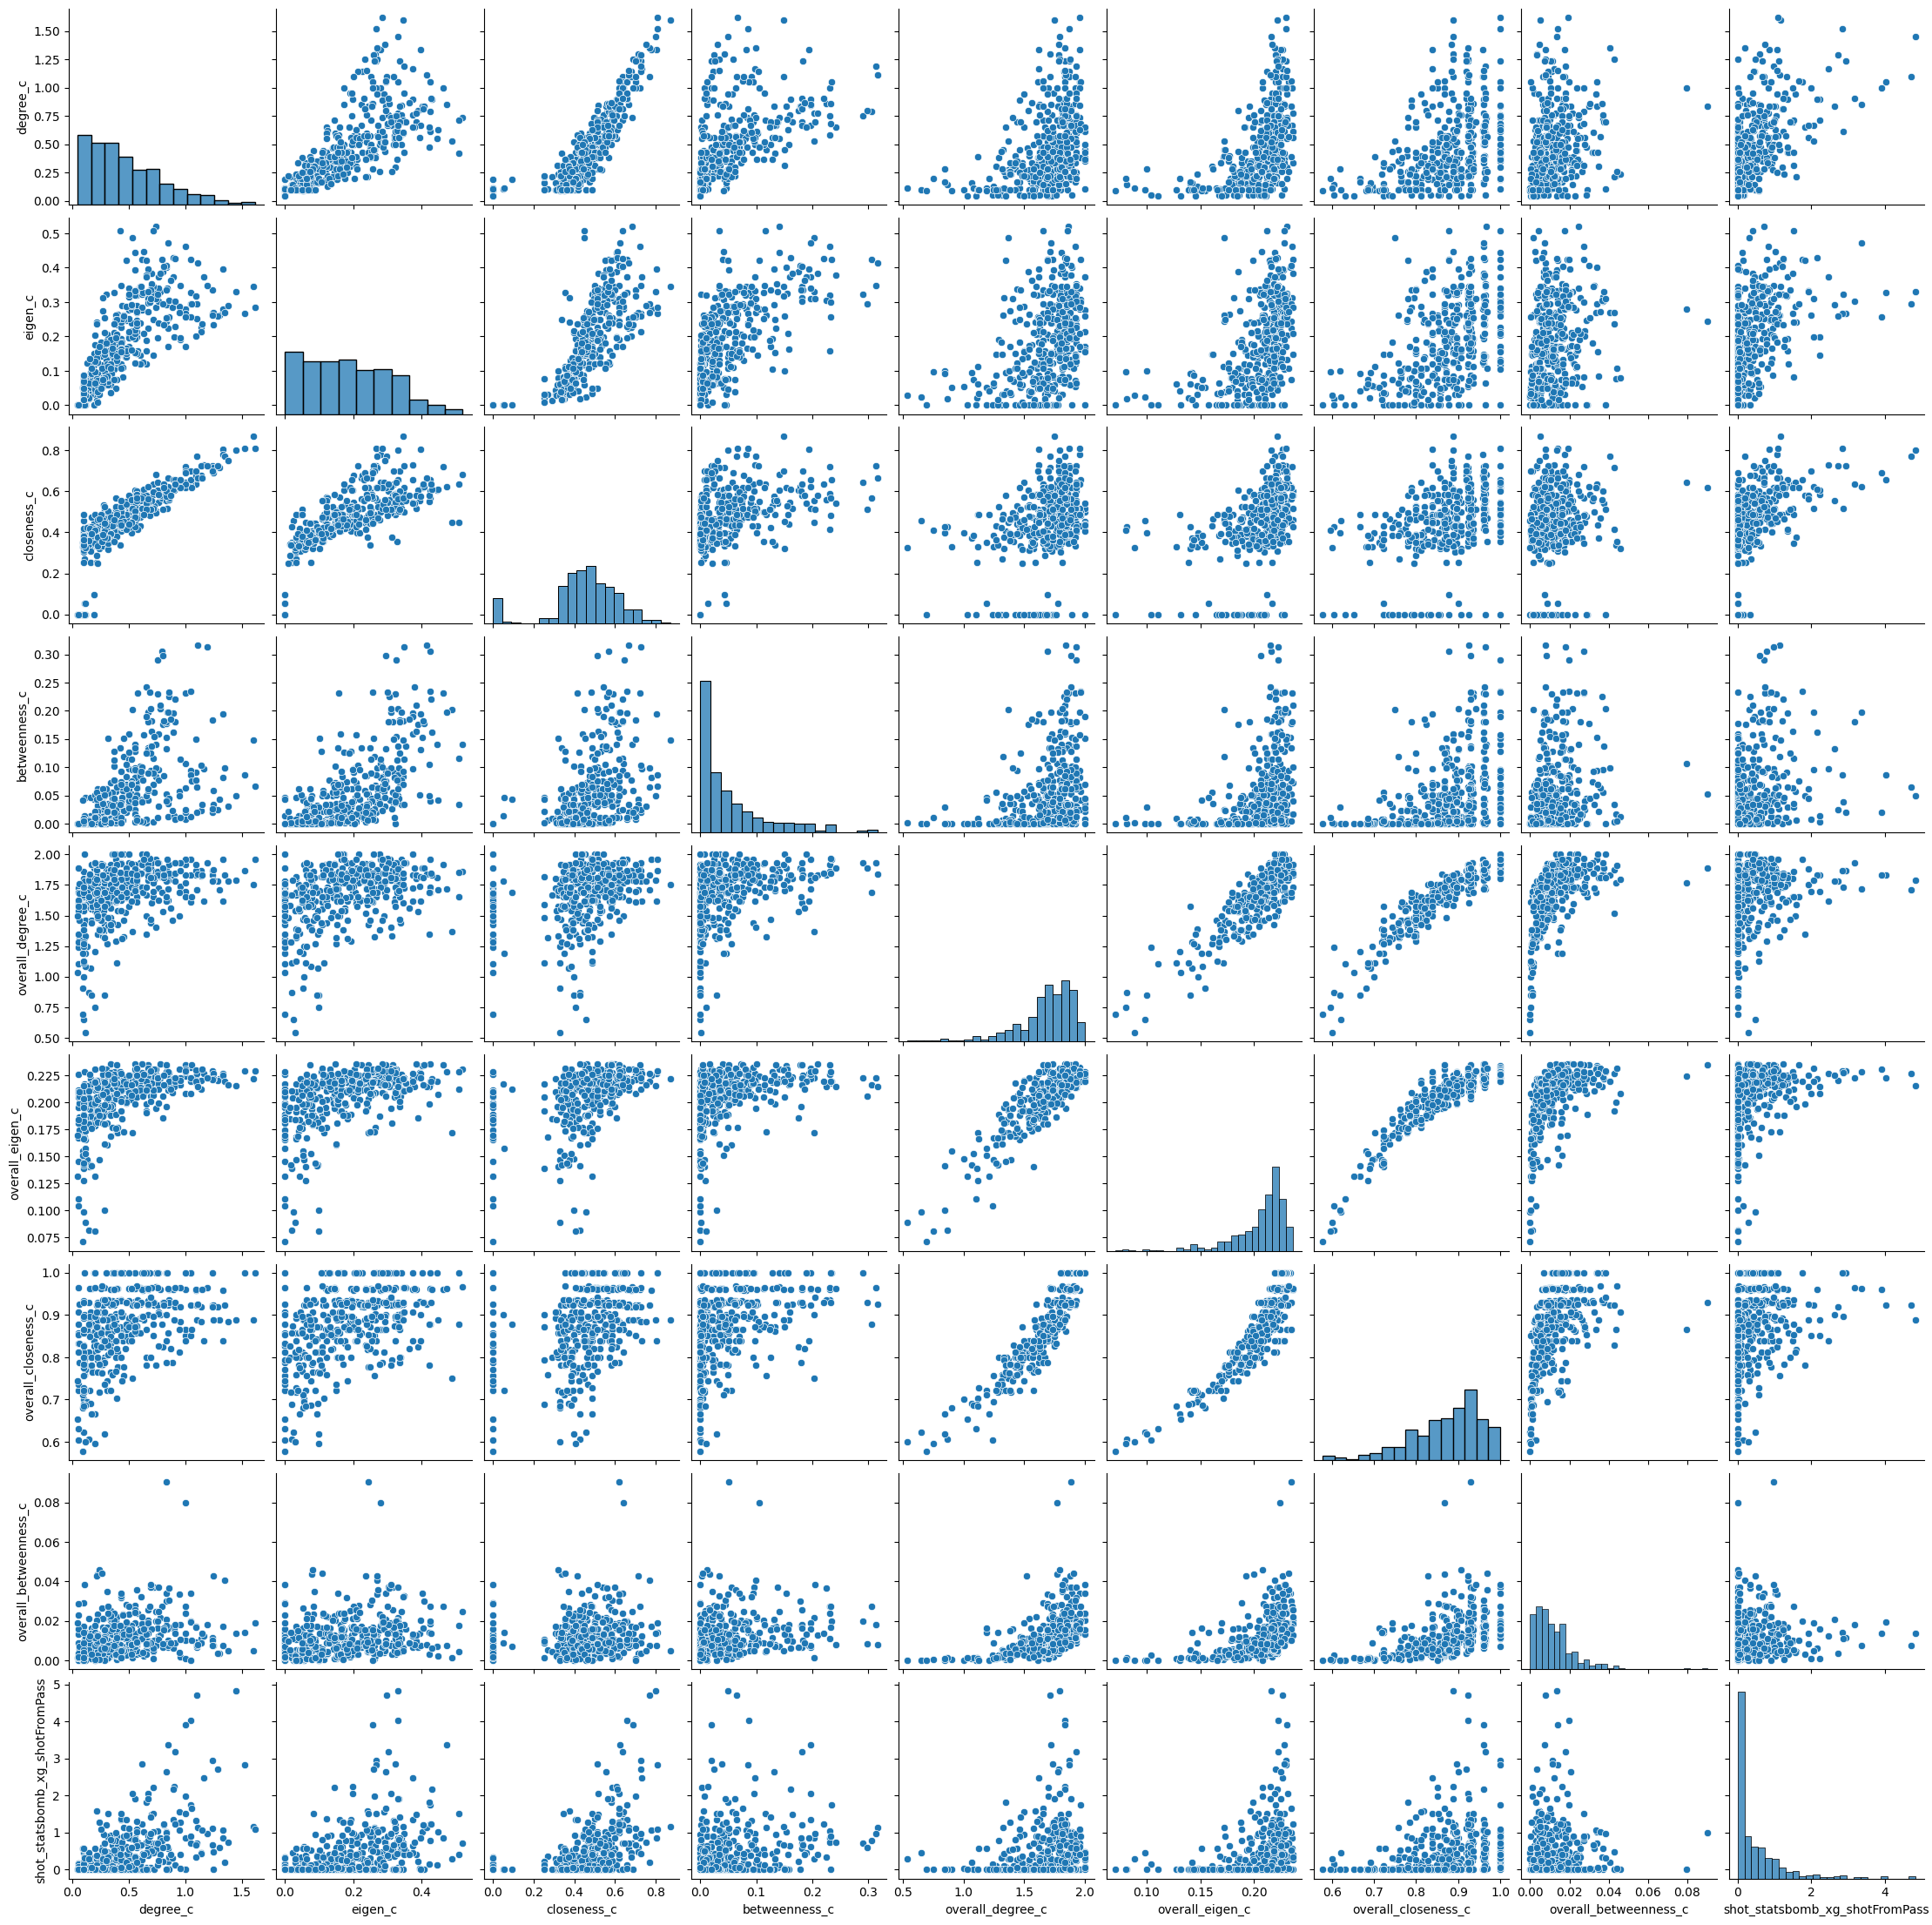

In [46]:
sns.pairplot(by_player_team[numerical_cols])


In [47]:

transformed_team = by_player_team.copy()
transformed_team.columns

Index(['player', 'degree_c', 'eigen_c', 'closeness_c', 'betweenness_c',
       'overall_degree_c', 'overall_eigen_c', 'overall_closeness_c',
       'overall_betweenness_c', 'shot_statsbomb_xg_shotFromPass'],
      dtype='object')

In [48]:

# Log transform for positive-skewed columns
for col in ['degree_c', 'betweenness_c']:
    transformed_team[col] = np.log(transformed_team[col] + 0.000001)  # +1 to handle zero values


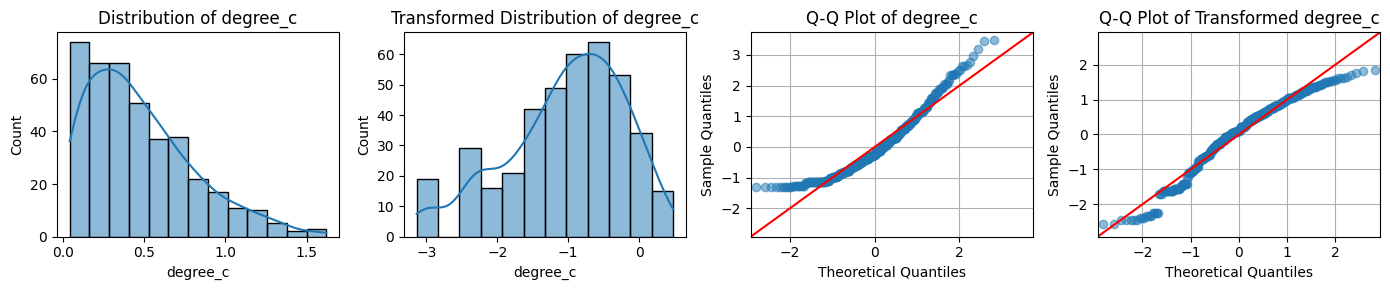

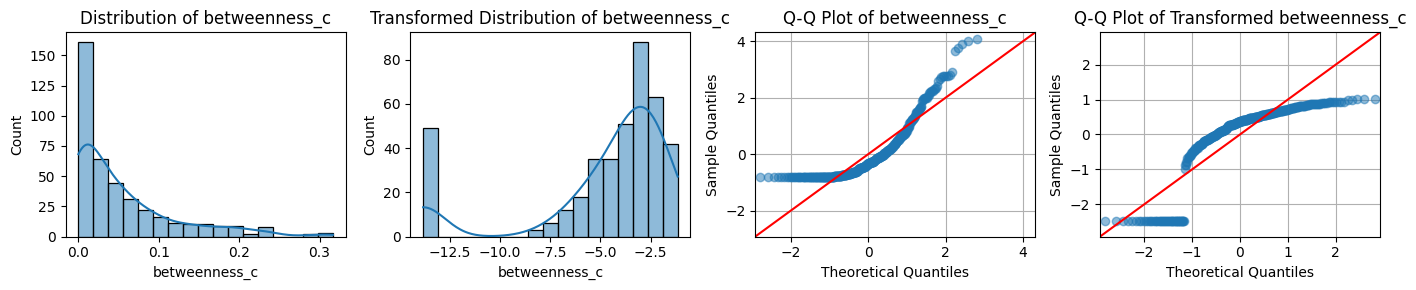

In [49]:

import statsmodels.api as sm

# Loop through numerical columns
for col in ['degree_c', 'betweenness_c']:    
    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 4, figsize=(14, 3))
    # Plot 1: Distribution Plot
    sns.histplot(by_player_team[col], kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of {col}")
    axes[0].set_xlabel(col)
    # Plot 1: Distribution Plot
    sns.histplot(transformed_team[col], kde=True, ax=axes[1])
    axes[1].set_title(f"Transformed Distribution of {col}")
    axes[1].set_xlabel(col)


    # Plot 2: Q-Q Plot with Confidence Intervals
    sm.qqplot(by_player_team[col], line='45', alpha=0.5, fit=True, ax=axes[2])
    axes[2].set_title(f"Q-Q Plot of {col}")
    axes[2].grid(True)


    # Plot 2: Q-Q Plot with Confidence Intervals
    sm.qqplot(transformed_team[col], line='45', alpha=0.5, fit=True, ax=axes[3])
    axes[3].set_title(f"Q-Q Plot of Transformed {col}")
    axes[3].grid(True)


    # Adjust layout and show plots
    plt.tight_layout()
    plt.show()

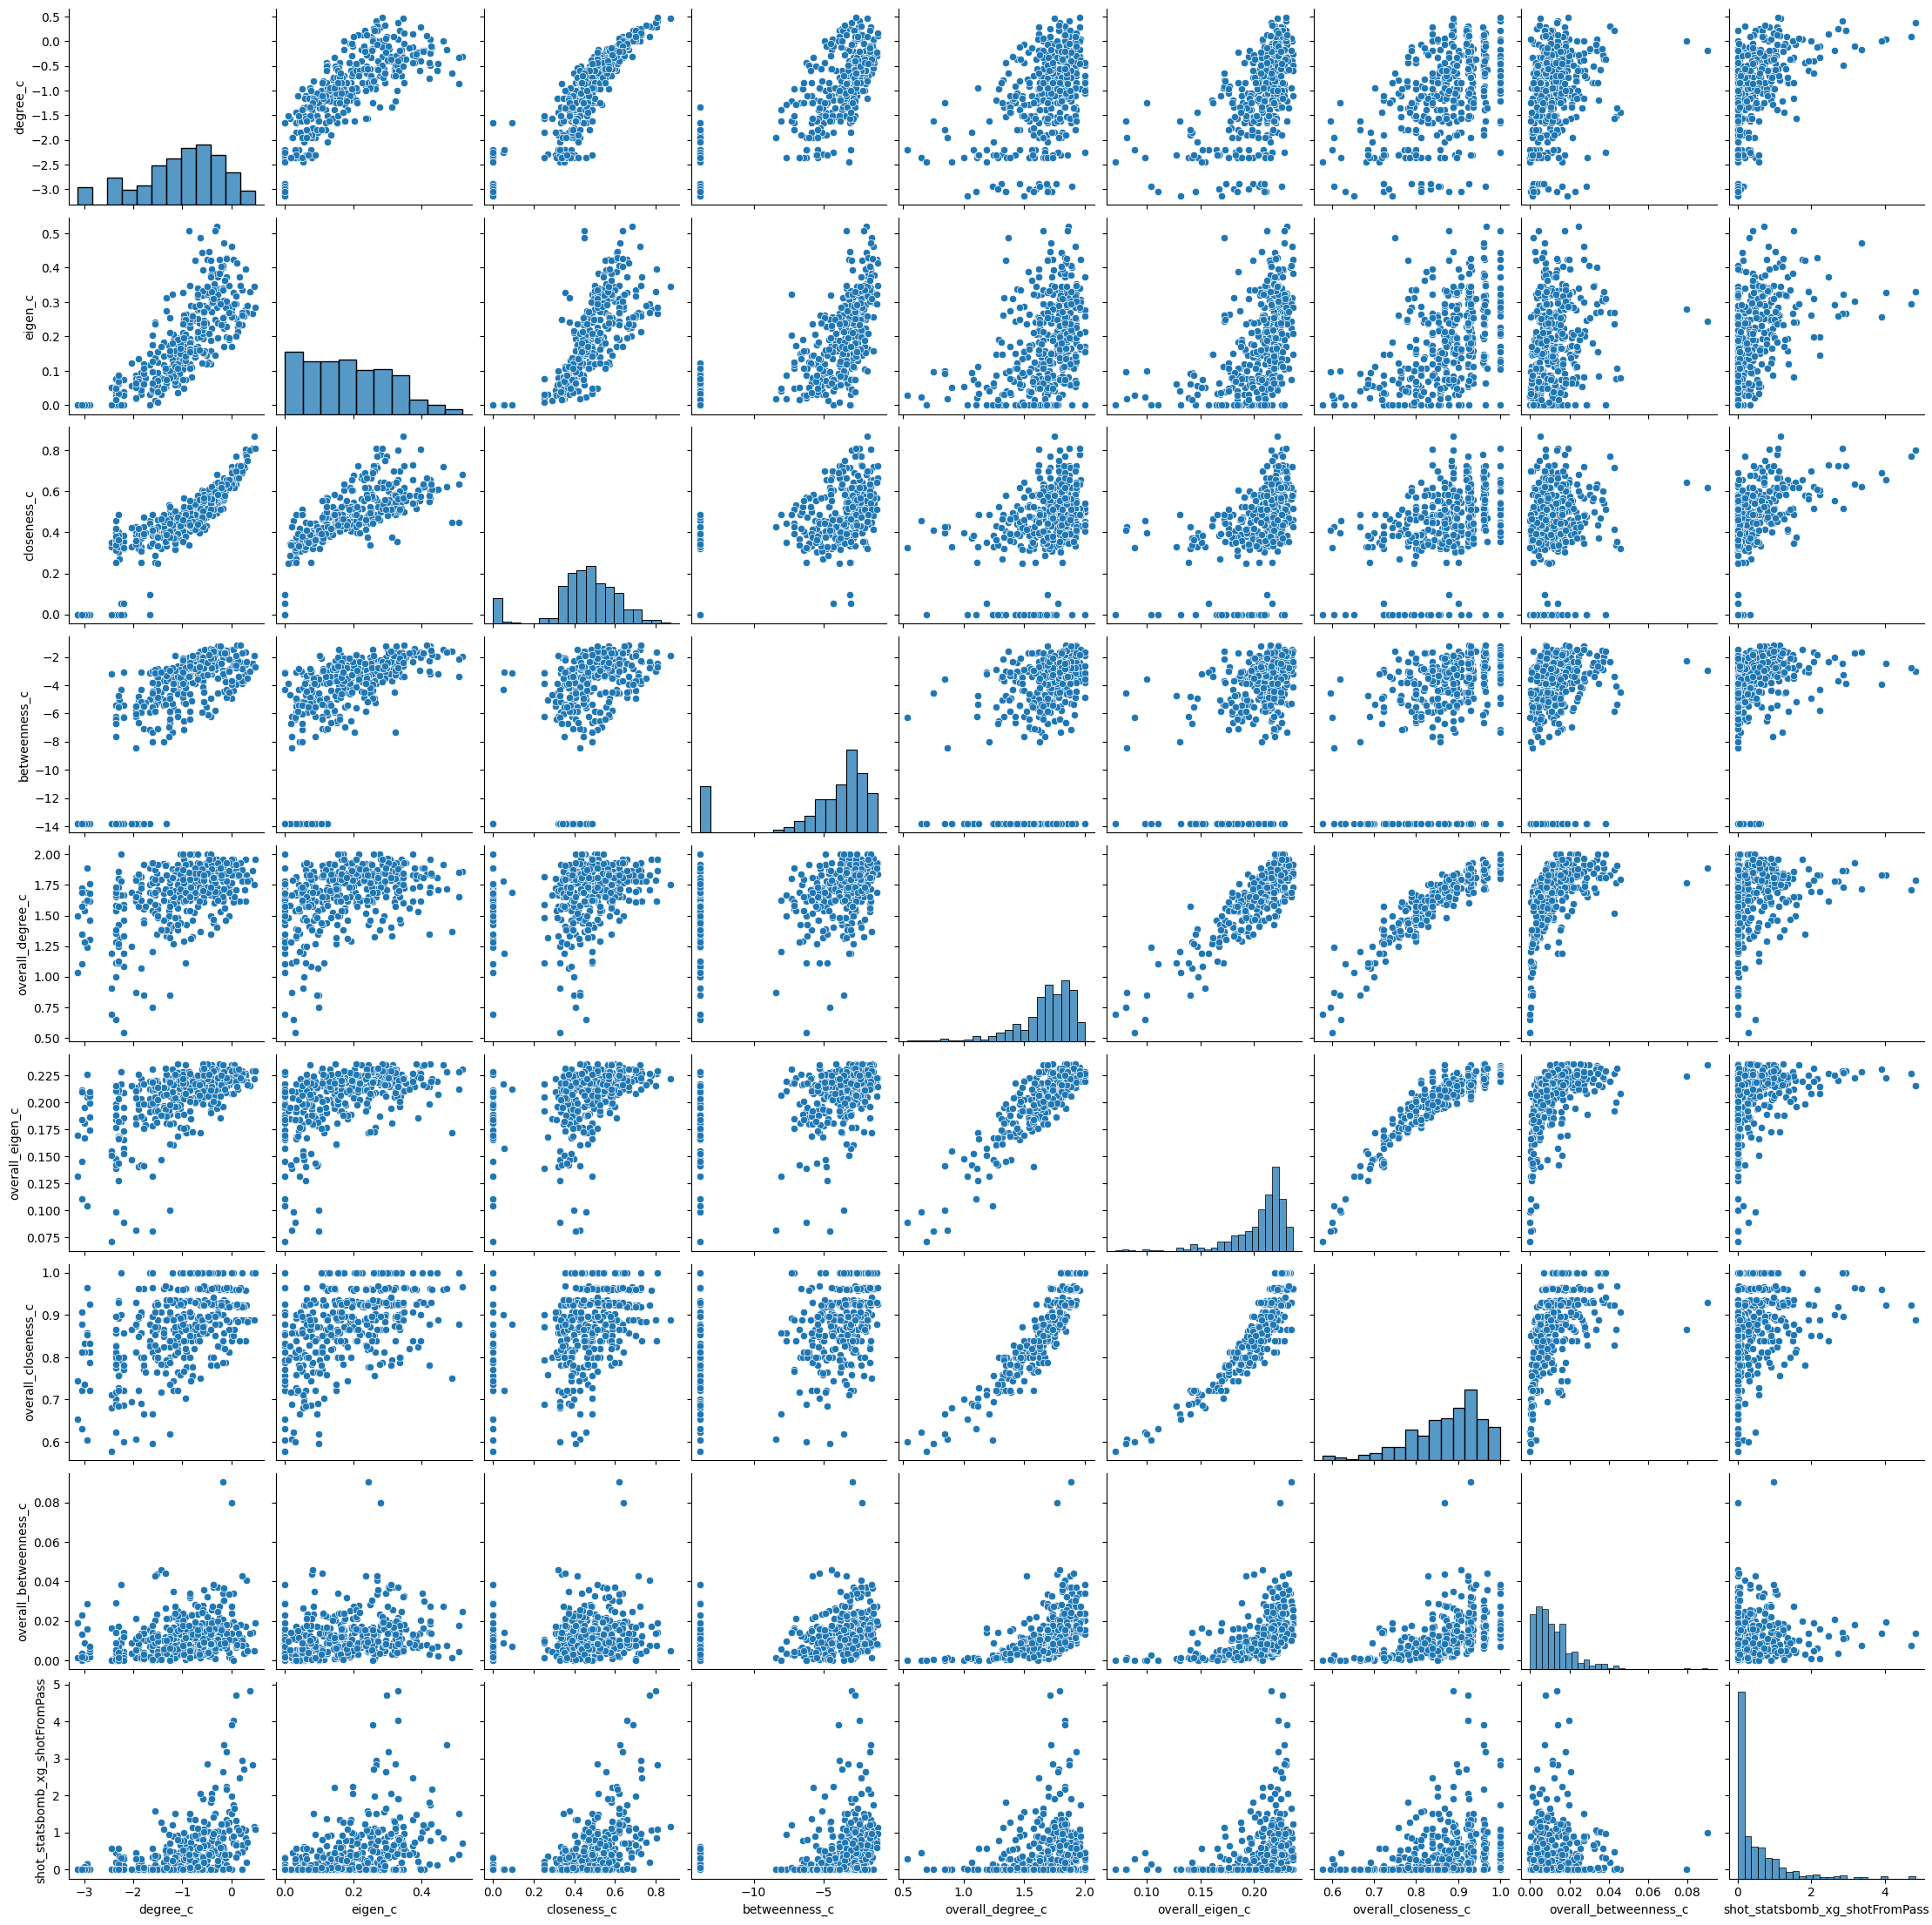

In [50]:
sns.pairplot(transformed_team[numerical_cols])


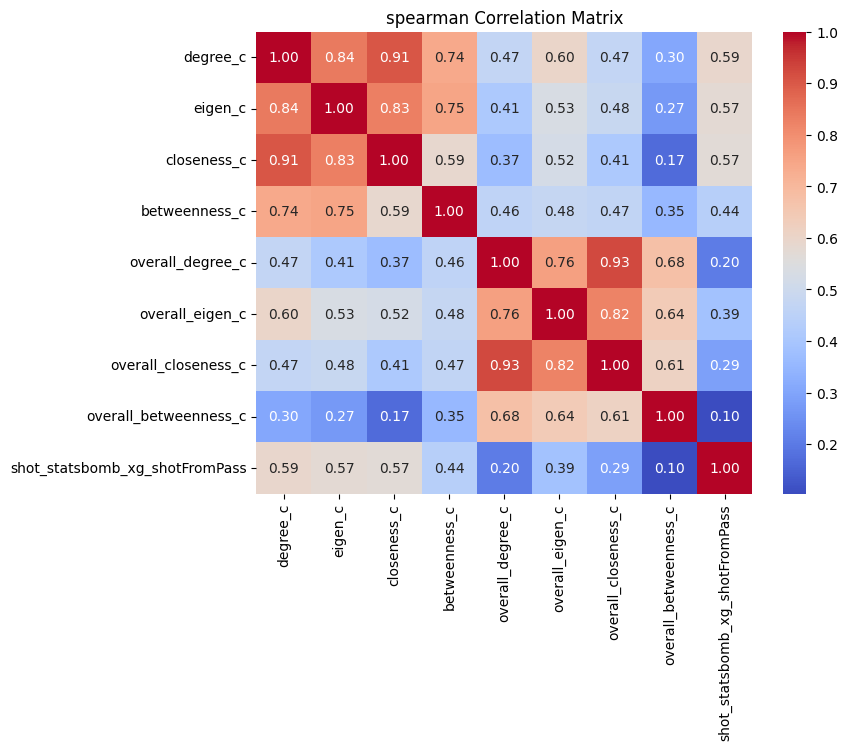

In [51]:
plt.figure(figsize=(8, 6))
sns.heatmap(transformed_team[numerical_cols].corr(method="spearman"), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("spearman Correlation Matrix")
plt.show()

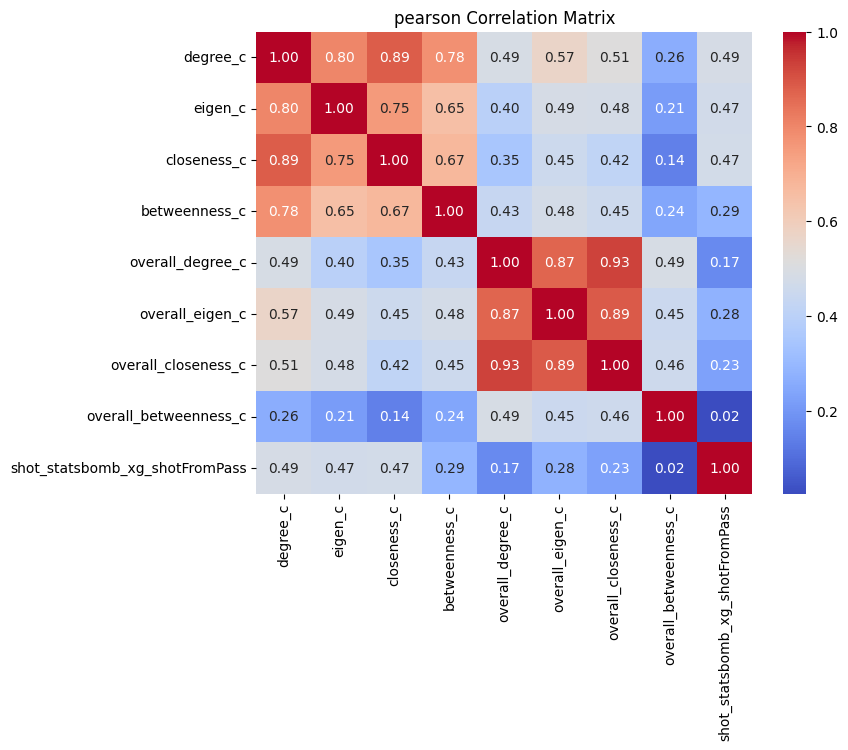

In [52]:
plt.figure(figsize=(8, 6))
sns.heatmap(transformed_team[numerical_cols].corr(method="pearson"), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("pearson Correlation Matrix")
plt.show()

Fitted Parameters: a = 0.00 ± 0.00, b = 23.10 ± 2.28


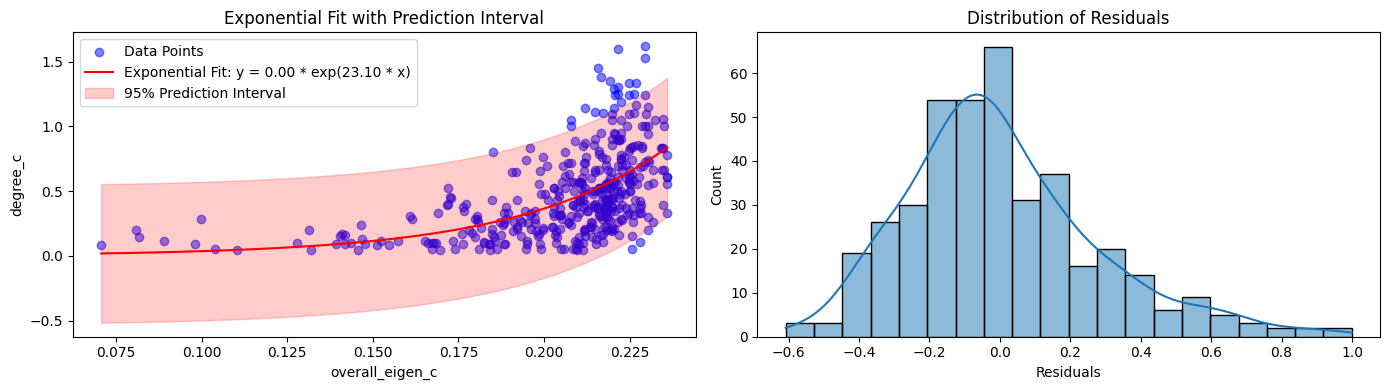

In [54]:
scatter_exp(by_player_team['overall_eigen_c'],by_player_team['degree_c'])

Fitted Parameters: a = 17.64 ± 1.27, b = -4.65 ± 0.26


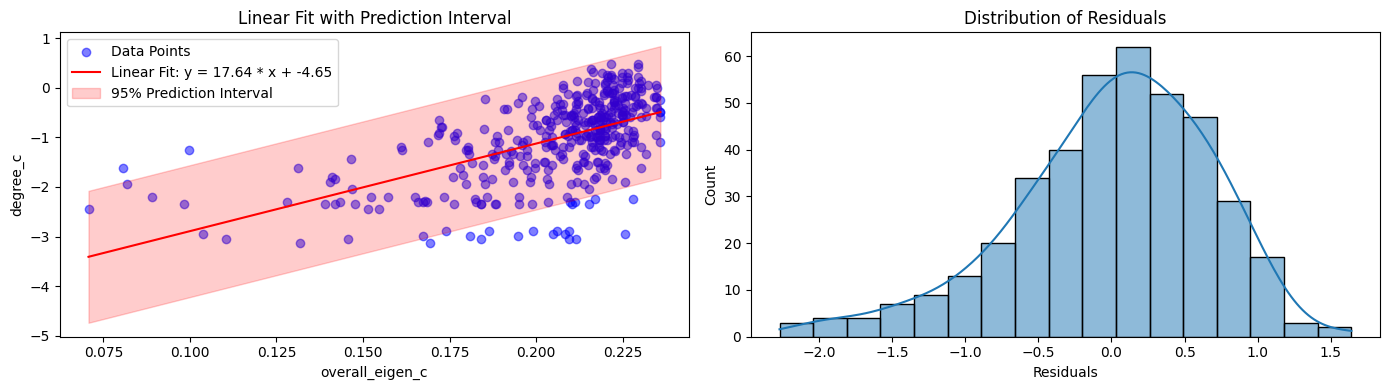

In [53]:
scatter_linear(transformed_team['overall_eigen_c'],transformed_team['degree_c'])

### Takım


In [347]:
by_player_match

player           team  match_id  degree_c   eigen_c  \
0          Abdoul Karim Yoda         Getafe    266498  1.615385  0.210081   
1          Abdoul Karim Yoda         Getafe   3825669  1.615385  0.210081   
2          Abdoul Karim Yoda         Getafe   3825697  1.615385  0.210081   
3          Abdoul Karim Yoda         Getafe   3825712  1.615385  0.210081   
4          Abdoul Karim Yoda         Getafe   3825737  1.615385  0.210081   
...                      ...            ...       ...       ...       ...   
10436  Óscar de Marcos Arana  Athletic Club   3825835  1.958333  0.225568   
10437  Óscar de Marcos Arana  Athletic Club   3825838  1.958333  0.225568   
10438  Óscar de Marcos Arana  Athletic Club   3825866  1.958333  0.225568   
10439  Óscar de Marcos Arana  Athletic Club   3825870  1.958333  0.225568   
10440  Óscar de Marcos Arana  Athletic Club   3825877  1.958333  0.225568   

       closeness_c  betweenness_c  shot_statsbomb_xg_shotFromPass  \
0         0.866667       0.002409                        0.000000   
1         0.866667       0.002409                        0.000000   
2         0.866667       0.002409                        0.000000   
3         0.866667       0.002409                        0.000000   
4         0.866667       0.002409                        0.044651   
...            ...            ...                             ...   
10436     1.000000       0.016095                        0.000000   
10437     1.000000       0.016095                        0.000000   
10438     1.000000       0.016095                        0.007785   
10439     1.000000       0.016095                        0.000000   
10440     1.000000       0.016095                        0.000000   

       SequenceBuildUpXG  SequenceXG  shot_outcome_shotFromPass_binary  
0               0.124778    0.124778                                 0  
1               0.000000    0.000000                                 0  
2               0.016870    0.016870                                 0  
3               0.000000    0.000000                                 0  
4               0.334633    0.379284                                 0  
...                  ...         ...                               ...  
10436           0.000000    0.000000                                 0  
10437           0.193370    0.193370                                 0  
10438           0.000000    0.007785                                 0  
10439           0.048042    0.048042                                 0  
10440           0.083317    0.083317                                 0  

[10441 rows x 11 columns]

In [384]:
all_teams_dataframe

scored_conceded = pd.concat([
    all_teams_dataframe[['match_id', 'home_team', 'home_score', 'away_score']].rename(
        columns={'home_team': 'team', 'home_score': 'scored', 'away_score': 'conceded'}),
    all_teams_dataframe[['match_id', 'away_team', 'away_score', 'home_score']].rename(
        columns={'away_team': 'team', 'away_score': 'scored', 'home_score': 'conceded'})
])

# Group by match_id and team
result = scored_conceded.groupby(['match_id', 'team'], as_index=False).mean()

result

match_id             team  scored  conceded
0      265839        Barcelona     2.0       1.0
1      265839          Sevilla     1.0       2.0
2      265894        Barcelona     2.0       1.0
3      265894           Málaga     1.0       2.0
4      265944        Barcelona     6.0       0.0
..        ...              ...     ...       ...
755   3825906          Sevilla     1.0       1.0
756   3825907  Atlético Madrid     1.0       2.0
757   3825907   Sporting Gijón     2.0       1.0
758   3825908            Eibar     2.0       4.0
759   3825908         Espanyol     4.0       2.0

[760 rows x 4 columns]

In [432]:
result = result[['team', 'scored', 'conceded']].groupby('team', as_index=False).sum()
result

team  scored  conceded
0            Athletic Club    58.0      45.0
1          Atlético Madrid    63.0      18.0
2                Barcelona   112.0      29.0
3               Celta Vigo    51.0      59.0
4                    Eibar    49.0      61.0
5                 Espanyol    40.0      74.0
6                   Getafe    37.0      67.0
7                  Granada    46.0      69.0
8               Las Palmas    45.0      53.0
9               Levante UD    37.0      70.0
10                  Málaga    38.0      35.0
11  RC Deportivo La Coruña    45.0      61.0
12          Rayo Vallecano    52.0      73.0
13              Real Betis    34.0      52.0
14             Real Madrid   110.0      34.0
15           Real Sociedad    45.0      48.0
16                 Sevilla    51.0      50.0
17          Sporting Gijón    40.0      62.0
18                Valencia    46.0      48.0
19              Villarreal    44.0      35.0

<Axes: xlabel='conceded', ylabel='Density'>

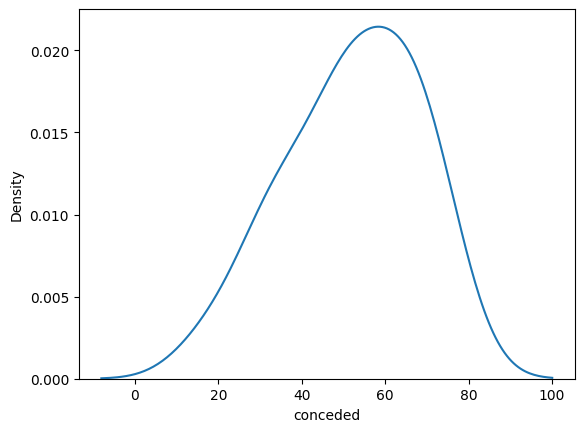

In [413]:
sns.kdeplot(result['conceded'])

In [443]:
result['scored'].describe()

count     20.00000
mean      52.15000
std       21.36469
min       34.00000
25%       40.00000
50%       45.50000
75%       51.25000
max      112.00000
Name: scored, dtype: float64

In [401]:
by_player_match[['player','team','degree_c','eigen_c','closeness_c','betweenness_c']].groupby(['player','team'],as_index=False).mean()

player             team  degree_c   eigen_c  \
0                   Abdoul Karim Yoda           Getafe  1.615385  0.210081   
1                  Abdoulaye Doucouré          Granada  1.370370  0.171872   
2           Abraham González Casanova         Espanyol  1.560000  0.189383   
3         Adalberto Peñaranda Maestre          Granada  1.592593  0.196177   
4    Aderllan Leandro de Jesus Santos         Valencia  1.655172  0.188509   
..                                ...              ...       ...       ...   
540              Íñigo Lekue Martínez    Athletic Club  1.875000  0.221813   
541            Íñigo Martínez Berridi    Real Sociedad  1.730769  0.211547   
542               Óliver Torres Muñoz  Atlético Madrid  1.833333  0.224816   
543          Óscar Esau Duarte Gaitán         Espanyol  1.440000  0.176130   
544             Óscar de Marcos Arana    Athletic Club  1.958333  0.225568   

     closeness_c  betweenness_c  
0       0.866667       0.002409  
1       0.750000       0.001477  
2       0.833333       0.002851  
3       0.818182       0.004457  
4       0.828571       0.029203  
..           ...            ...  
540     0.960000       0.007572  
541     0.866667       0.008227  
542     0.923077       0.009136  
543     0.781250       0.003070  
544     1.000000       0.016095  

[545 rows x 6 columns]

In [404]:
len(by_player_match['player'].unique())

538

In [436]:
merged_df = pd.merge(by_player_match[['player','team','degree_c','eigen_c','closeness_c','betweenness_c']].groupby(['player','team'],as_index=False).mean(), result, on=['team'], how='inner')
merged_df

player             team  degree_c   eigen_c  \
0                   Abdoul Karim Yoda           Getafe  1.615385  0.210081   
1                  Abdoulaye Doucouré          Granada  1.370370  0.171872   
2           Abraham González Casanova         Espanyol  1.560000  0.189383   
3         Adalberto Peñaranda Maestre          Granada  1.592593  0.196177   
4    Aderllan Leandro de Jesus Santos         Valencia  1.655172  0.188509   
..                                ...              ...       ...       ...   
540              Íñigo Lekue Martínez    Athletic Club  1.875000  0.221813   
541            Íñigo Martínez Berridi    Real Sociedad  1.730769  0.211547   
542               Óliver Torres Muñoz  Atlético Madrid  1.833333  0.224816   
543          Óscar Esau Duarte Gaitán         Espanyol  1.440000  0.176130   
544             Óscar de Marcos Arana    Athletic Club  1.958333  0.225568   

     closeness_c  betweenness_c  scored  conceded  
0       0.866667       0.002409    37.0      67.0  
1       0.750000       0.001477    46.0      69.0  
2       0.833333       0.002851    40.0      74.0  
3       0.818182       0.004457    46.0      69.0  
4       0.828571       0.029203    46.0      48.0  
..           ...            ...     ...       ...  
540     0.960000       0.007572    58.0      45.0  
541     0.866667       0.008227    45.0      48.0  
542     0.923077       0.009136    63.0      18.0  
543     0.781250       0.003070    40.0      74.0  
544     1.000000       0.016095    58.0      45.0  

[545 rows x 8 columns]

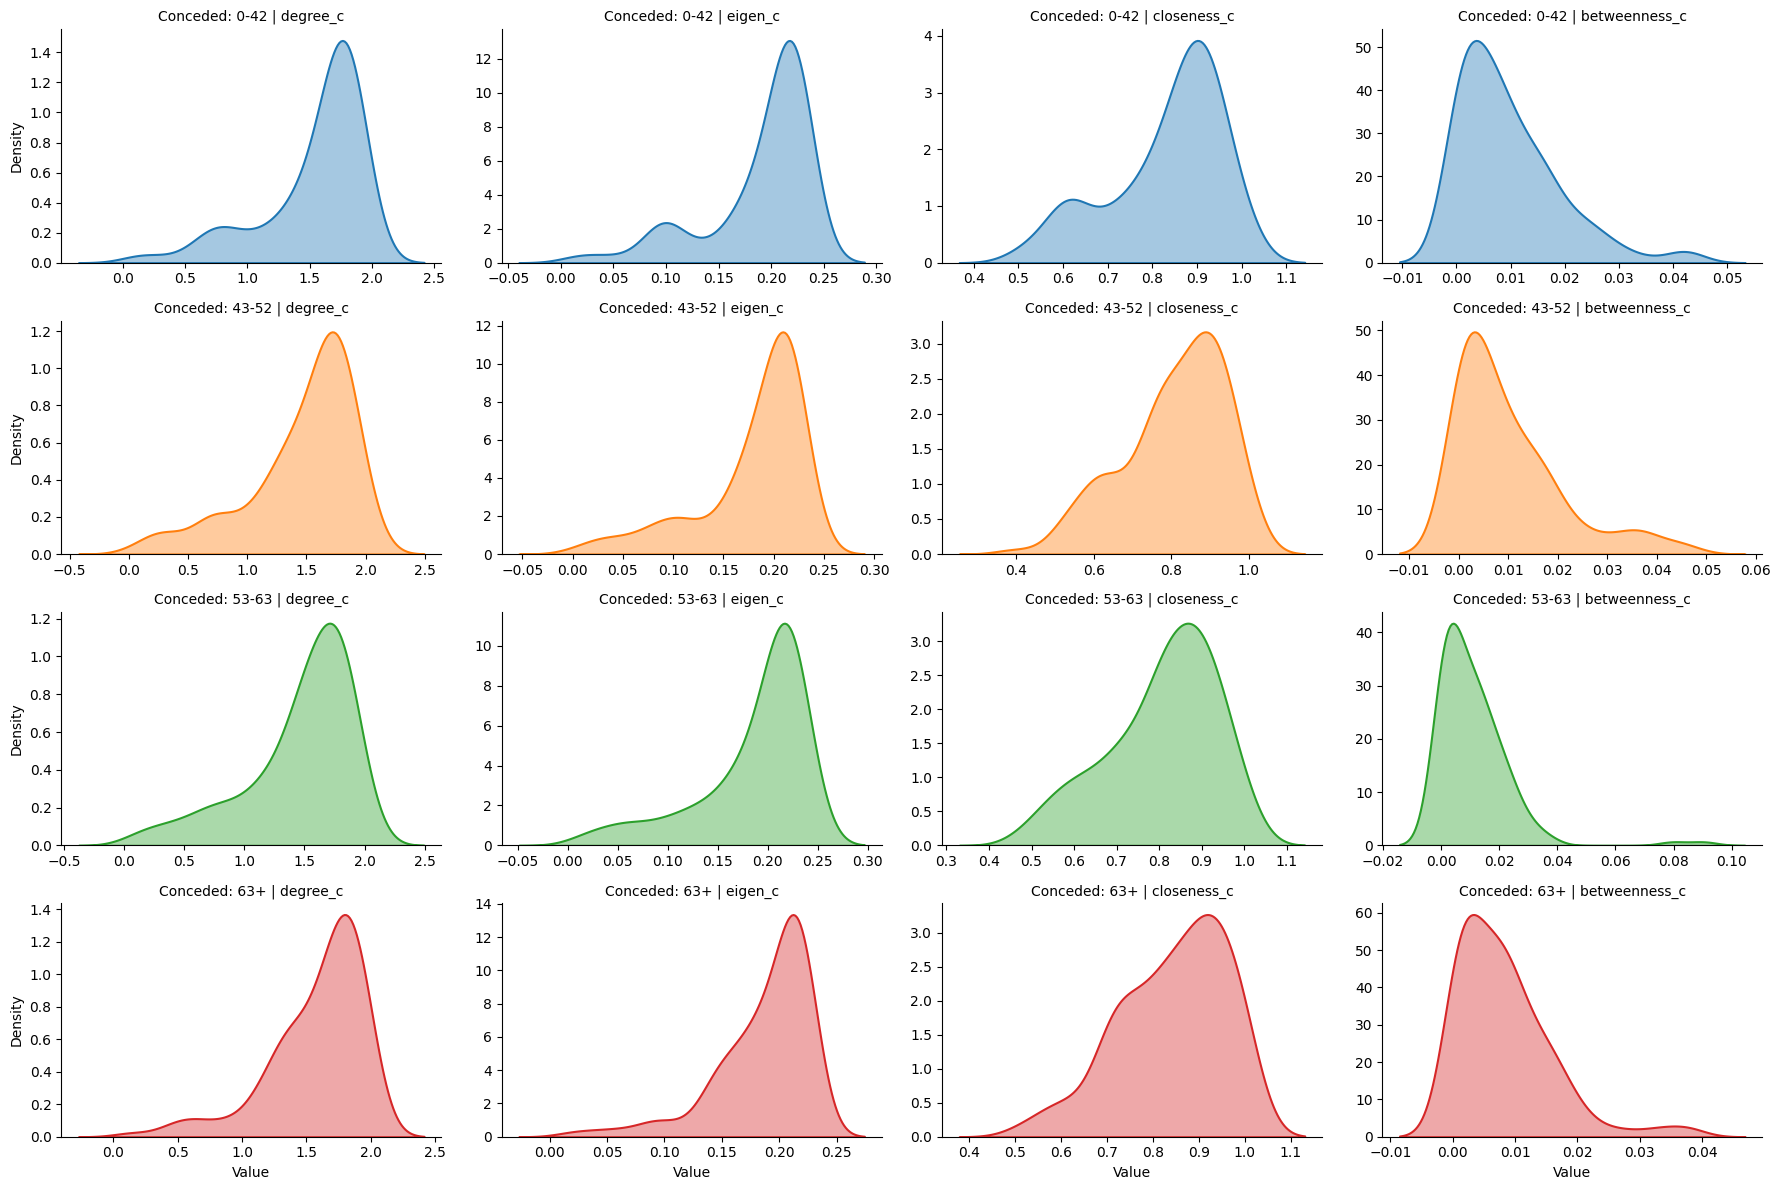

In [441]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the metrics to plot
metrics = ['degree_c', 'eigen_c', 'closeness_c', 'betweenness_c']

# Bin the conceded goals into 4 categories
merged_df['conceded_category'] = pd.cut(
    merged_df['conceded'],
    bins=[0, 42, 52, 63, float('inf')],  # Define bins for conceded goals
    labels=['0-42', '43-52', '53-63', '63+'],  # Labels for the bins
    right=True
)

# Melt the DataFrame to create a "long" format for plotting
melted_df = merged_df.melt(
    id_vars=['team', 'conceded_category'],  # Include team and conceded categories
    value_vars=metrics,  # Metrics to unpivot
    var_name='metric',  # New column for metric names
    value_name='value'  # New column for metric values
)

# Define a custom color palette for categories
category_palette = {
    '0-42': '#1f77b4',  # Blue
    '43-52': '#ff7f0e',  # Orange
    '53-63': '#2ca02c',  # Green
    '63+': '#d62728'  # Red
}

# Create a FacetGrid for 4-row, 4-column layout
g = sns.FacetGrid(
    melted_df,
    row='conceded_category',  # Rows represent conceded categories
    col='metric',  # Columns represent metrics
    sharex=False,  # Allow different x-axis ranges for each metric
    sharey=False,  # Allow different y-axis ranges for each metric
    height=3,
    aspect=1.5  # Control the aspect ratio of the plots
)

# Custom plotting function to assign colors manually
def plot_kde(data, **kwargs):
    category = data['conceded_category'].iloc[0]  # Get the current category
    color = category_palette[str(category)]  # Map the category to a color
    sns.kdeplot(data=data, x='value', fill=True, alpha=0.4, linewidth=1.5, color=color)

# Map the custom plotting function
g.map_dataframe(plot_kde)

# Add titles and adjust layout
g.set_titles(row_template="Conceded: {row_name}", col_template="{col_name}")
g.set_axis_labels("Value", "Density")
g.tight_layout()

# Show the plot
plt.show()


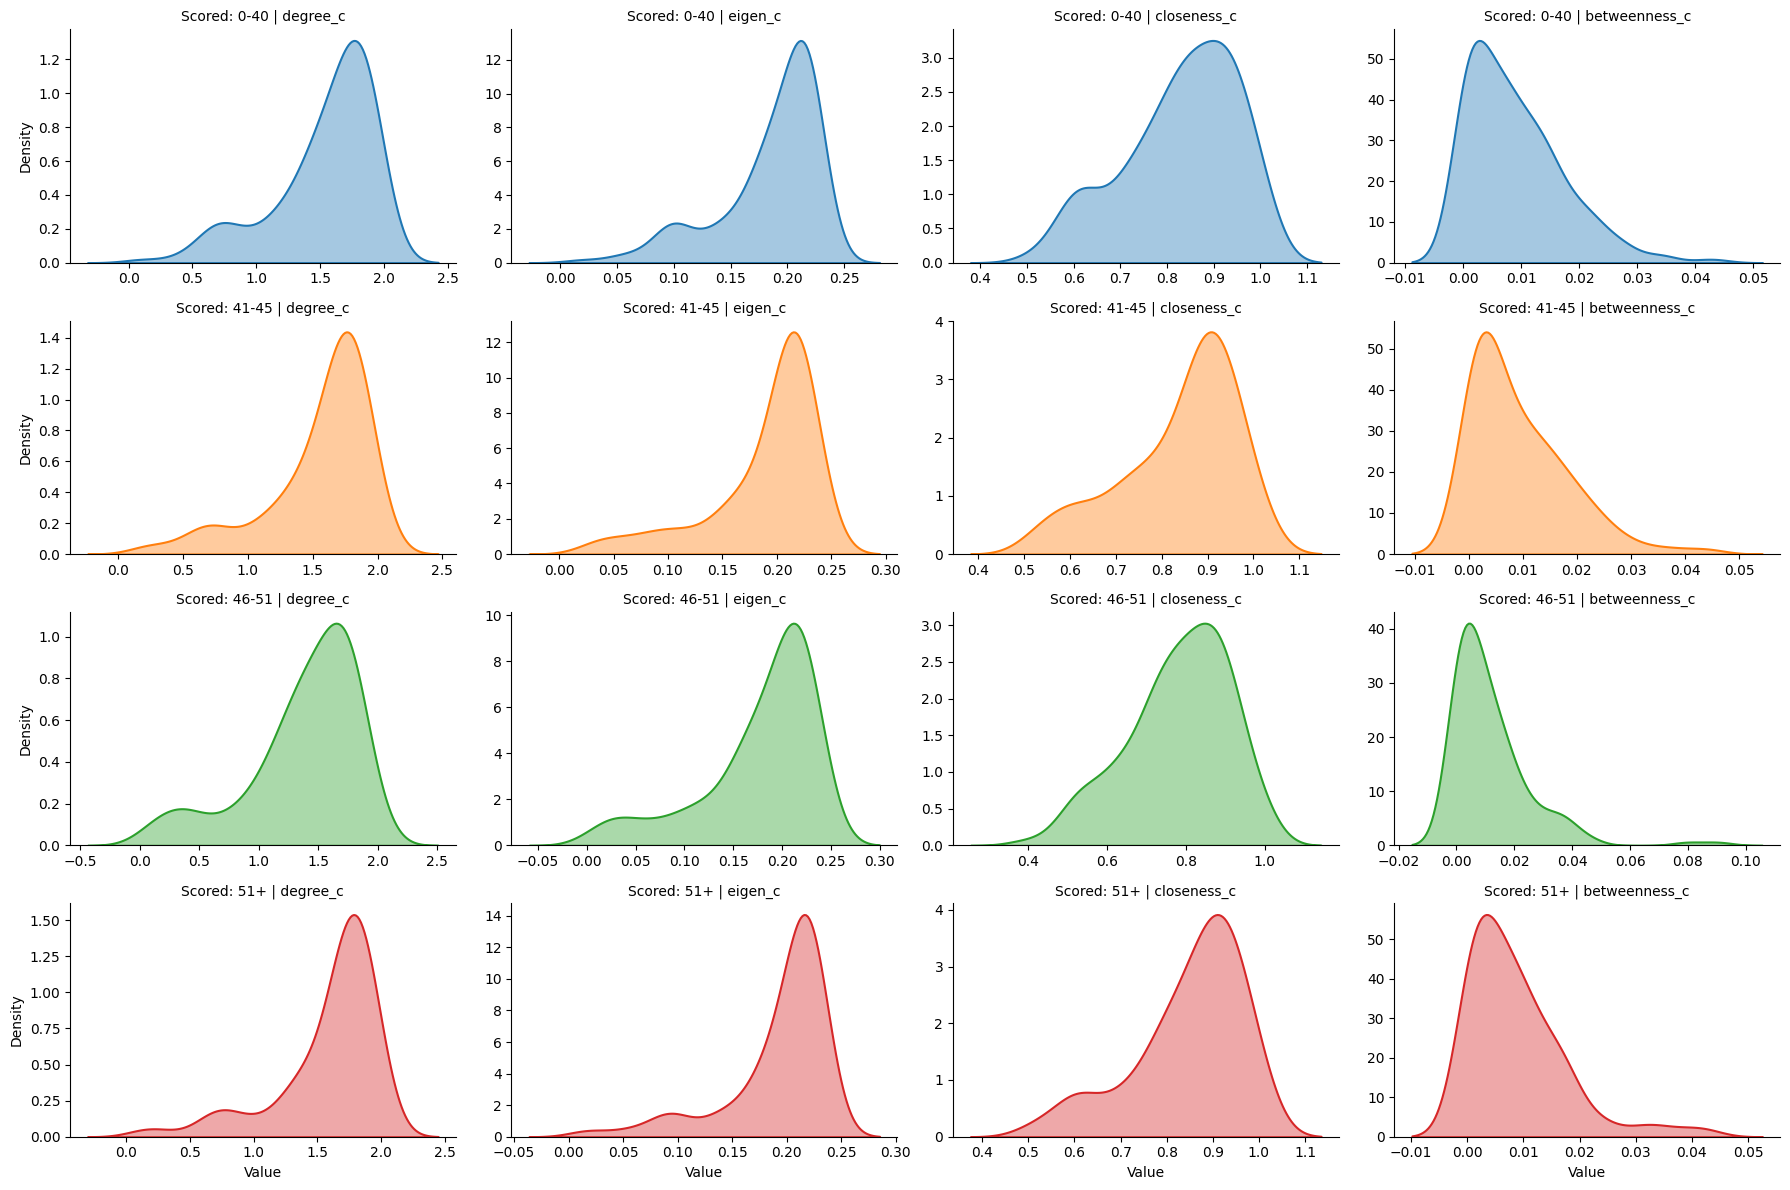

In [445]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the metrics to plot
metrics = ['degree_c', 'eigen_c', 'closeness_c', 'betweenness_c']

# Bin the conceded goals into 4 categories
merged_df['scored_category'] = pd.cut(
    merged_df['scored'],
    bins=[0, 40, 45, 51, float('inf')],  # Define bins for conceded goals
    labels=['0-40', '41-45', '46-51', '51+'],  # Labels for the bins
    right=True
)

# Melt the DataFrame to create a "long" format for plotting
melted_df = merged_df.melt(
    id_vars=['team', 'scored_category'],  # Include team and conceded categories
    value_vars=metrics,  # Metrics to unpivot
    var_name='metric',  # New column for metric names
    value_name='value'  # New column for metric values
)

# Define a custom color palette for categories
category_palette = {
    '0-40': '#1f77b4',  # Blue
    '41-45': '#ff7f0e',  # Orange
    '46-51': '#2ca02c',  # Green
    '51+': '#d62728'  # Red
}

# Create a FacetGrid for 4-row, 4-column layout
g = sns.FacetGrid(
    melted_df,
    row='scored_category',  # Rows represent conceded categories
    col='metric',  # Columns represent metrics
    sharex=False,  # Allow different x-axis ranges for each metric
    sharey=False,  # Allow different y-axis ranges for each metric
    height=3,
    aspect=1.5  # Control the aspect ratio of the plots
)

# Custom plotting function to assign colors manually
def plot_kde(data, **kwargs):
    category = data['scored_category'].iloc[0]  # Get the current category
    color = category_palette[str(category)]  # Map the category to a color
    sns.kdeplot(data=data, x='value', fill=True, alpha=0.4, linewidth=1.5, color=color)

# Map the custom plotting function
g.map_dataframe(plot_kde)

# Add titles and adjust layout
g.set_titles(row_template="Scored: {row_name}", col_template="{col_name}")
g.set_axis_labels("Value", "Density")
g.tight_layout()

# Show the plot
plt.show()


In [56]:
con.close

<bound method PyCapsule.close of <duckdb.duckdb.DuckDBPyConnection object at 0x107f48230>>